# G3 - HarmonySeeker: Data's Rhythm is all you need
_Machine Learning II Project - Songs Success Classifier_

Members:  

Luca Zosso  
Frenando  
Marguarita   
Kriztian 
Jacopo  
Alise  

## CONTEXT



#### Loading necessary python packages

In [1]:
#Basic Libs
import pandas as pd

import numpy as np


# Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score,classification_report, precision_score, roc_curve, auc, precision_recall_fscore_support, precision_recall_curve


from sklearn.decomposition import PCA  
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Vizualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#warnings
import warnings

warnings.filterwarnings("ignore")

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### Data Mining

Throughout this section we are going to load the our raw dataset, explore it in order to check what has to be done in terms of feature engineering. This part will allow us to highlight the most important information, which will help to improve model accuracy. 

#### Our Feature Engineering Process

In this project, we have undertaken several feature engineering steps to prepare our dataset for the predictive modeling phase. These steps include:

1. **Data Cleaning**: We started by handling missing values.
2. **Feature Transformations**: 
    * Creation of track_age variable with the year column
    * Creation of tonality variable concatinating mode + key
    * Creation of Dominant Genres in order to reduce the subgenres in artist_genres column
    * Audio Features, using a dimension reduction tehcnique (PCA) reducing these high correlated variables into 5 indexes.

Through these steps, we have enhanced our dataset, making it more suitable for the machine learning models that follow. The next sections will delve into the specifics of the modeling process and the outcomes of our feature-engineered dataset.

3. **Target Variable: Binning Strategy**:
    In this section we will present you our bining strategy to define the frontiers of our model.

4. **Notes**:  
    This process was done in parallel with EDA, in order to determined the different tasks to preprocess our dataset. Throughout our study we have encountered some biases on the initial dataset that should be taken into account. For instance, ```track_popularity``` and ```artist_popularity column``` are based on 2022 data. We understood that these popularity scale was based on 2022 where as our goal is to provide track success which involved more temporality. This will be detailed in the binning strategy section.


In this section we are going to conduct the data mining process which involves collecting and cleaning raw data, exploring and transforming it to reveal patterns, and applying various algorithms to build models that extract valuable insights. 

In [2]:
#Loading the raw dataset
path = "/Users/lucazosso/Desktop/IE_Course/Term_2/Machine Learning II/Group Assignement/data/Songs_2024.xlsx"
data = pd.read_excel(path, sheet_name=1)
data1 = data.copy()
print(data1.shape)


(2300, 19)


##### __Track Age__:  
By looking at the table above, we noticed that it's more descriptive to change the year variable into a new one called "track_age_2024" to show how much time passed since it was relesed. 

In [3]:
#dealing with teh year column
data1['track_age_2024'] =  data1['year'].map(lambda x: 2024-x)


##### __Sub Genres Challenges__:  
In this part we first check how many unique sub_genres exists in our dataset, then we will be creating an algorithm that enables us to map these subgenres to parent genres that we called "dominant genres" for each track. We used REGEX in our process in order to map new sungenres that might emerge for lasting purposes.

In [4]:
#dealing with sub genres
import re
#check number of unique sub_genres
genres_list = []
for genres_str in data1["artist_genres"]:
    cleaned_str = re.sub(r"[\[\]']", "", genres_str)
    genres = cleaned_str.split(';')
    for genre in genres:
        genres_list.append(genre.strip())

print(f"There are {len(set(genres_list))} different sub genres present in the dataset")

There are 438 different sub genres present in the dataset


In [5]:
#Dealing the genres
# Convert 'artist_genres' from string representation of a list to an actual list
# The genres are separated by ';', so we split on this character
data1['artist_genres'] = data1['artist_genres'].apply(lambda x: x.strip("[]").replace("'", "").split("; "))

# Define the genre mapping
mapping = {
    "pop": ['pop', 'pop punk', 'dance pop', 'europop', 'girl group', 'pop rap', 'bahamian pop', 'canadian pop', 'pop dance', 'post-teen pop', 'boy band', 'art pop', 'metropopolis', 'barbadian pop', 'viral pop', 'candy pop', 'australian pop', 'folk-pop', 'k-pop', 'bubblegum dance', 'pop dance'],
    "rock": ['permanent wave', 'alternative metal', 'modern rock', 'punk', 'rock', 'socal pop punk', 'alternative rock', 'dance rock', 'pop rock', 'celtic rock', 'irish rock', 'grunge', 'uk pop', 'neo mellow', 'piano rock', 'pov: indie', 'modern alternative rock', 'neon pop punk', 'garage rock', 'indie rock', 'canadian rock', 'british invasion', 'emo','neo-psychedelic','screamo','glam metal','beatlesque','madchester','supergroup'],
    "country": ['contemporary country', 'country', 'country dawn', 'country road'],
    "hip_hop_rap": ['detroit hip hop', 'hip hop', 'rap', 'dirty south rap', 'hip pop', 'east coast hip hop', 'hardcore hip hop', 'gangster rap', 'west coast rap', 'st louis rap', 'trap', 'southern hip hop', 'atl hip hop', 'melodic rap', 'miami hip hop', 'chicago rap', 'canadian hip hop', 'old school atlanta hip hop', 'queens hip hop', 'crunk', 'conscious hip hop', 'trap queen', 'south carolina hip hop', 'new orleans rap', 'G Funk','brooklyn drill','hyphy','atlanta bass'],
    "rnb_soul": ['contemporary r&b', 'r&b', 'urban contemporary', 'british soul', 'neo soul', 'pop soul', 'canadian contemporary r&b','soul','pluggnb'],
    "house_and_pop_fusion" : ['disco house', 'filter house', 'bouncy house', 'electro house', 'slap house', 'tropical house', 'pop dance', 'house', 'progressive house', 'indietronica', 'progressive electro house', 'uk garage', 'big room', 'complextro'],
    "underground_electronic" : ['electro', 'big beat', 'downtempo', 'melbourne bounce international', 'electro trash', 'grave wave', 'dark clubbing', 'ukg revival', 'hardcore techno', 'grime', 'instrumental grime', 'dancefloor dnb', 'trance', 'speed garage','new wave','bounce','handsup','chicago hardcore','rave','german techno','hamburg electronic','happy hardcore', 'industrial','techno'],
    "metal": ['nu metal', 'post-grunge', 'rap metal', 'funk metal', 'industrial metal'],
    "jazz": ['jazz', 'smooth jazz', 'bebop', 'swing', 'fusion jazz', 'stomp and holler'],
    "classical": ['classical', 'baroque', 'romantic', 'symphony', 'opera'],
    "reggae": ['reggae', 'dancehall', 'reggae fusion', 'dub', 'roots reggae','moombahton'],
    "latin": ['latin', 'reggaeton', 'latin pop', 'salsa', 'bachata', 'merengue', 'tango', 'cumbia', 'trap latino', 'urbano latino', 'mexican pop', 'colombian pop', 'mambo chileno','urbano chileno', 'tropical'],
    "singer-songwriter": ['singer-songwriter pop', 'singer-songwriter'],
    "folk":['folk','classic schlager', 'oktoberfest', 'schlager', 'celtic','middle earth','sertanejo','sertanejo universitario'],
    "talent show": ['talent show']
}

# Flatten the mapping for easier access
flat_mapping = {}
for main_genre, subgenres in mapping.items():
    for subgenre in subgenres:
        flat_mapping[subgenre] = main_genre

# Function to categorize genres
def categorize_genres(genres_list, mapping):
    genre_counts = {}
    for genre in genres_list:
        for subgenre, main_genre in mapping.items():
            if subgenre in genre:
                genre_counts[main_genre] = genre_counts.get(main_genre, 0) + 1
    if genre_counts:
        # Return the most frequent main genre, if tie, sorted order decides
        return max(genre_counts, key=genre_counts.get)
    else:
        return "other"  # or "other" if you prefer to label unmatched genres as "other"

# Apply the categorization function
data1['dominant_genre'] = data1['artist_genres'].apply(lambda x: categorize_genres(x, flat_mapping))

print(f"After preprocessing we have now: \n {data1['dominant_genre'].unique()} parent genres")


After preprocessing we have now: 
 ['rock' 'country' 'pop' 'rnb_soul' 'hip_hop_rap' 'house_and_pop_fusion'
 'metal' 'other' 'folk' 'latin' 'underground_electronic' 'jazz' 'reggae'
 'talent show' 'singer-songwriter'] parent genres


##### __Tonality Variable__:  
Here the challenge was that the ```key``` column was numric within a range of 0 to 11, introducing this to the model will create some ambiguities as music keys wouldn't have the same weight. We decided to create a tonality variable that capture the key and the mode of each track.

In [6]:
#dealing with keys
# Define the mapping dictionary for music keys
key_mapping = {0.: 'C',1.: 'C#',2.: 'D',3: 'D#',4.: 'E',5.: 'F',6.: 'F#',7.: 'G',8.: 'G#',9.: 'A',10.: 'A#',11.: 'B'}

data1['key'] = data1['key'].map(key_mapping)

#dealing w/mode
tone = {0 : 'min', 1: 'Maj'}
data1['mode'] = data1['mode'].map(tone)

#create tonality
data1['tonality'] = data1['key'] + data1['mode']


##### Checking null values

In [8]:
null_rows = data1[data1.isnull().any(axis=1)]
print(null_rows)
data1.dropna(inplace=True)


     year   track_name  track_popularity      album          artist_name  \
447  2004  These Words                68  Unwritten  Natasha Bedingfield   

                       artist_genres  artist_popularity  danceability  energy  \
447  [dance pop, pop, post-teen pop]                 64           NaN     NaN   

     key  ...  speechiness acousticness  instrumentalness  liveness  valence  \
447  NaN  ...          NaN          NaN               NaN       NaN      NaN   

     tempo  duration_ms  track_age_2024  dominant_genre  tonality  
447    NaN          NaN              20             pop       NaN  

[1 rows x 22 columns]


##### Finaly We arrived with the following dataframe

Note that the _bining strategy_ and the _dimension reduction_ of the ``audio features`` will be done introduced after the EDA part.

In [9]:
print(data1.columns)
print(data1.shape)

Index(['year', 'track_name', 'track_popularity', 'album', 'artist_name',
       'artist_genres', 'artist_popularity', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'duration_ms', 'track_age_2024',
       'dominant_genre', 'tonality'],
      dtype='object')
(2299, 22)


In [10]:
data1.to_csv("./data_mined.csv")

### Some Exploratory Data Analysis

* Dataset: 2,299 tracks spanning 2000 to 2022.
* Popularity: Track and artist popularity averages are roughly 71 and 73, with ranges from 0 to 100.
* Danceability and Energy: Averages near 0.66 and 0.69, indicating tracks are generally danceable and energetic.
* Loudness: Varies widely from -56 to 132 dB, average around 73 dB.
* Acousticness and Instrumentalness: Low averages suggest electronic over acoustic and predominantly vocal tracks.
* Tempo: Averages at 120.51 BPM, accommodating a variety of music styles.
* Duration: Tracks last from about 97 seconds to over 11 minutes, averaging around 3.77 minutes.
* Age: Tracks range from 2 to 24 years old by 2024, with a median age of 13 years.

__Meta Data__

| Column Name | Description |
|-------------|-------------|
| year | year |
| track_name | track name |
| track_popularity | track popularity from 0 to 100 |
| album | album the track appears on |
| artist_name | artist name |
| artist_genres | list of the Genres the artist is associated with |
| artist_popularity | artist popularity from 0 to 100, being the maximum |
| danceability | a value of 0.0 is least danceable and 1.0 is most danceable |
| energy | a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity, being 1.0 the maximum |
| key | The key the track is in. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C,  1 = C♯/D♭,  2 = D  and so on |
| loudness | The overall loudness of a track in decibels (dB) |
| mode | Modality (major or minor) of a track. Major = 1 and minor = 0 |
| speechiness | Detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. |
| acousticness | A confidence measure from 0.0 to 1.0 of whether the track is acoustic |
| instrumentalness | Predicts whether a track contains no vocals |
| liveness | Detects the presence of an audience in the recording |
| valence | a measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track |
| tempo | The overall estimated tempo of a track in beats per minute (BPM) |
| duration_ms | The duration of the track in milliseconds |
| track_age_2024 | Age of the track from 2024 |
| dominant genre | Global Genre (manual classification) |

In [17]:
data_clean = pd.read_csv("data_mined.csv")
data_clean = data_clean.drop(columns=['Unnamed: 0'])
data_clean.head()



,year,track_name,track_popularity,album,artist_name,artist_genres,artist_popularity,danceability,energy,key,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,track_age_2024,dominant_genre,tonality
0,2000,Yellow,91,Parachutes,Coldplay,"['permanent wave', 'pop']",86,0.429,0.661,B,...,0.0281,0.00239,0.000121,0.2340,0.285,173.372,266773.0,24,rock,BMaj
1,2000,All The Small Things,84,Enema Of The State,blink-182,"['alternative metal', 'modern rock', 'pop punk...",75,0.434,0.897,C,...,0.0488,0.01030,0.000000,0.6120,0.684,148.726,167067.0,24,rock,CMaj
2,2000,Breathe,69,Breathe,Faith Hill,"['contemporary country', 'country', 'country d...",61,0.529,0.496,G,...,0.0290,0.17300,0.000000,0.2510,0.278,136.859,250547.0,24,country,GMaj
3,2000,In the End,88,Hybrid Theory (Bonus Edition),Linkin Park,"['alternative metal', 'nu metal', 'post-grunge...",83,0.556,0.864,D#,...,0.0584,0.00958,0.000000,0.2090,0.400,105.143,216880.0,24,rock,D#min
4,2000,Bye Bye Bye,74,No Strings Attached,*NSYNC,"['boy band', 'dance pop', 'pop']",65,0.610,0.926,G#,...,0.0479,0.03100,0.001200,0.0821,0.861,172.638,200400.0,24,pop,G#min


In [18]:
#Some discreption of the dataset
data_clean.describe().T

,count,mean,std,min,25%,50%,75%,max
year,2299.0,2011.003045,6.634528,2000.000000,2005.00000,2011.0000,2017.000000,2022.000
track_popularity,2299.0,70.944759,12.294047,0.000000,66.00000,72.0000,79.000000,100.000
artist_popularity,2299.0,72.873423,12.180506,29.000000,65.00000,74.0000,82.000000,100.000
danceability,2299.0,0.660116,0.141137,0.162000,0.57200,0.6710,0.759500,0.975
energy,2299.0,0.693047,0.164838,0.051900,0.58600,0.7120,0.820000,0.999
loudness,2299.0,73.006960,15.643937,-56.000000,63.00000,74.0000,83.000000,132.000
speechiness,2299.0,0.097795,0.092445,0.022500,0.03800,0.0568,0.115500,0.576
acousticness,2299.0,0.157689,0.203844,0.000013,0.01650,0.0689,0.223000,0.978
instrumentalness,2299.0,0.013766,0.083990,0.000000,0.00000,0.0000,0.000054,0.985
liveness,2299.0,0.172618,0.131620,0.021000,0.08995,0.1190,0.220000,0.843


##### Track Popularity

Top 100 Popular Songs

In [19]:
Top_100 = data_clean[['dominant_genre','artist_name','track_name','track_popularity','artist_popularity']].query('track_popularity > 90').sort_values('track_popularity', ascending=False)
Top_100.head(100)

,dominant_genre,artist_name,track_name,track_popularity,artist_popularity
1902,pop,Taylor Swift,Cruel Summer,100,100
2011,pop,Taylor Swift,august,93,100
2201,pop,Taylor Swift,Anti-Hero,93,100
2285,pop,David Guetta,I'm Good (Blue),93,86
1599,rnb_soul,The Weeknd,Starboy,92,94
2161,rnb_soul,The Weeknd,Blinding Lights,92,94
2226,rock,OneRepublic,I Ain't Worried,92,81
2288,pop,Rema,Calm Down (with Selena Gomez),92,77
0,rock,Coldplay,Yellow,91,86
1302,rock,The Neighbourhood,Sweater Weather,91,81


Top 100 least popular song

In [20]:
Bottom_100 = data_clean[['dominant_genre','artist_name','track_name','track_popularity','artist_popularity']].sort_values('track_popularity', ascending=True)
Bottom_100.head(100)

,dominant_genre,artist_name,track_name,track_popularity,artist_popularity
2069,hip_hop_rap,Machine Gun Kelly,my ex's best friend (with blackbear),0,75
2169,hip_hop_rap,Pop Smoke,What You Know Bout Love,0,79
399,hip_hop_rap,Fatman Scoop,Be Faithful,0,57
2001,pop,Ariana Grande,positions,0,87
2144,pop,Lorde,Solar Power,0,74
...,...,...,...,...,...
2000,pop,Taylor Swift,cardigan,53,100
295,other,City High,Caramel,53,43
294,pop,*NSYNC,Girlfriend,53,65
293,pop,A1,Caught in the Middle,53,47


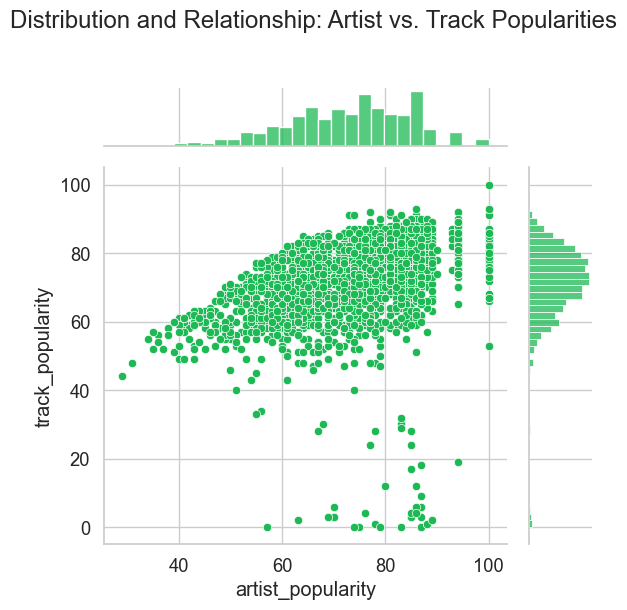

In [21]:
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2)

# Create a joint plot
sns.jointplot(x='artist_popularity', y='track_popularity', data=data_clean, kind='scatter', color='#1db954')

# Set labels and title
plt.xlabel('artist_popularity')
plt.ylabel('track_popularity')
plt.suptitle('Distribution and Relationship: Artist vs. Track Popularities', y=1.02)

# Show the plot
plt.tight_layout()
plt.show()

 "Distribution and Relationship: Artist vs. Track Popularities". The graph is a combination of a scatter plot and histograms. On the scatter plot, the x-axis represents 'artist_popularity' and the y-axis represents 'track_popularity', both ranging from 0 to 100. The plot shows a positive correlation between artist and track popularities, with most data points clustered towards the higher end of both axes. The histograms on the top and right side of the scatter plot illustrate the distribution of track popularities and artist popularities, respectively, indicating a right-skewed distribution for both. This suggests that there are fewer artists and tracks with very high popularity, and more with moderate popularity.

##### Distributions of Tracks by genre & Track popularity

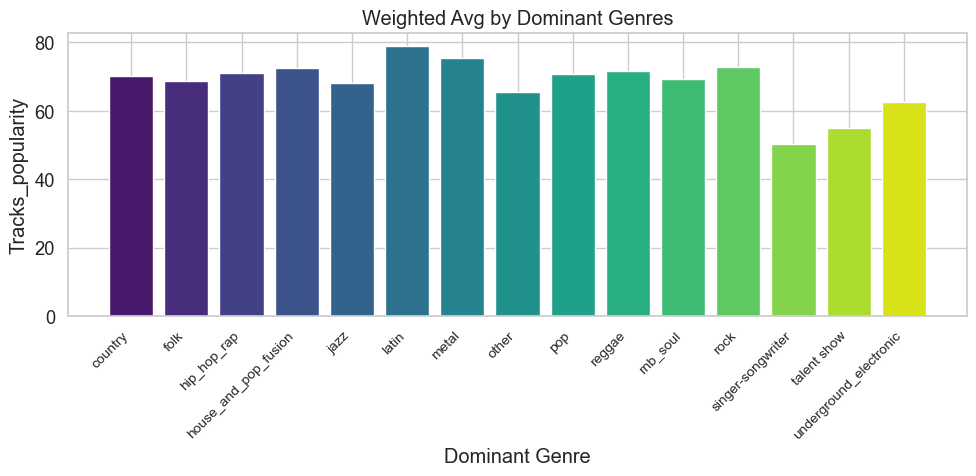

In [22]:
# Calculate genre counts
# Assuming df is your DataFrame
#data_clean.reset_index(inplace=True)
# // Count //
#genre_counts = data_clean.groupby('dominant_genre')['song_id'].count()

# // AVG //
genre_counts = data_clean.groupby('dominant_genre')['track_popularity'].mean()

## // Weighted //


# Set up the bar plot
plt.figure(figsize=(10, 5))
viridis_palette = sns.color_palette("viridis", n_colors=len(genre_counts))

# Plot the bar plot with 'viridis' color palette
bar_plot = plt.bar(genre_counts.index, genre_counts, color=viridis_palette)
plt.xticks(rotation=45, ha='right', fontsize=10)  # Adjust rotation and font size

# Add a title and axis labels
plt.title('Weighted Avg by Dominant Genres')
plt.xlabel('Dominant Genre')
plt.ylabel('Tracks_popularity')

# Prevent overlapping of x-axis labels
plt.tight_layout()

# Show the plot
plt.show()

The chart displays the 'Track popularity' on the y-axis, ranging from around 40 to 80, against various 'Dominant Genres' on the x-axis. The genres include country, electronic, hip-hop/rap, jazz, latin, metal, other, pop, reggae, r&b/soul, rock, singer/songwriter, and talent show. The bars are colored in shades of purple and green, possibly indicating different categories or levels within the genres. The bars are fairly even in height, suggesting that track popularity is somewhat consistent across these genres, with only slight variations. The code snippet visible above the chart indicates that the plot is designed to prevent overlapping of x-axis labels and to display the plot properly using matplotlib in Python.

plotting energy variation accross genre

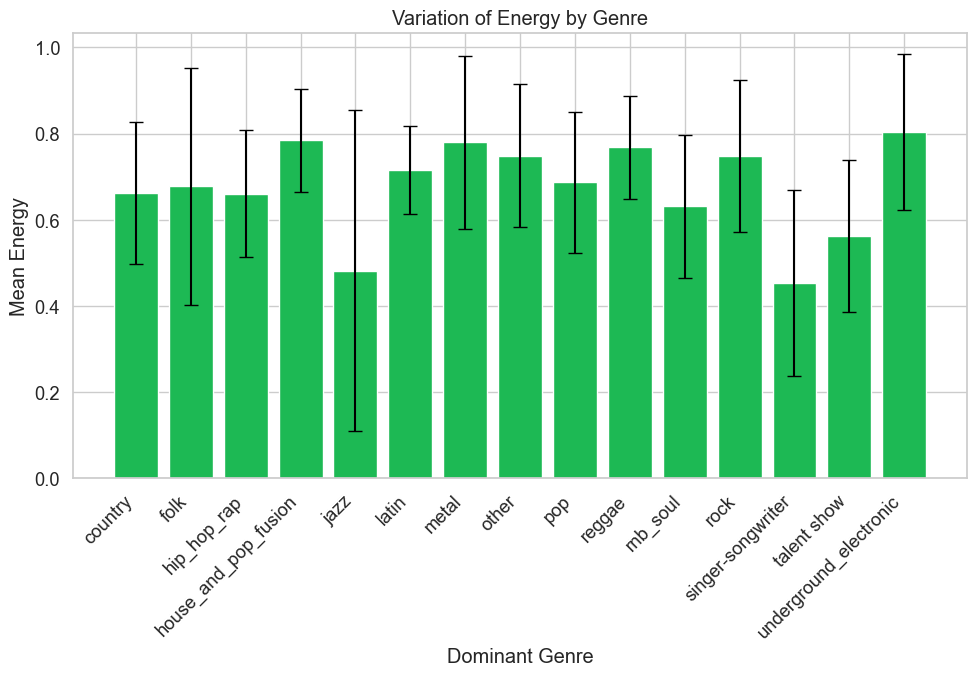

In [23]:
plt.figure(figsize=(10, 7))
sns.set_context("notebook", font_scale=1.2)

# Calculate mean energy and standard deviation by genre
energy_stats = data_clean.groupby('dominant_genre')['energy'].agg(['mean', 'std']).reset_index()

# Create the bar plot with error bars
plt.bar(energy_stats['dominant_genre'], energy_stats['mean'], color='#1db954', yerr=energy_stats['std'], capsize=5)

# Add labels and title
plt.xlabel('Dominant Genre')
plt.ylabel('Mean Energy')
plt.title('Variation of Energy by Genre')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()

This is a bar chart titled "Variation of Energy by Genre". The y-axis represents 'Mean Energy', ranging from 0 to 1, and the x-axis lists various 'Dominant Genres' including country, folk, hip-hop/rap, house and pop/fusion, jazz, latin, metal, other, pop, r&b/soul, rock, singer/songwriter, talent show, and underground/electronic. Each genre has a green bar representing the average energy level of tracks within that genre, and error bars extending from each bar suggest the variance in energy levels within each genre. The error bars indicate that while the mean energy levels are similar across some genres, there is a considerable spread in the energy levels within each genre. This visualization helps to understand the distribution and diversity of energy within musical tracks across different genres.

##### Exploring the popular dominant genres through the year

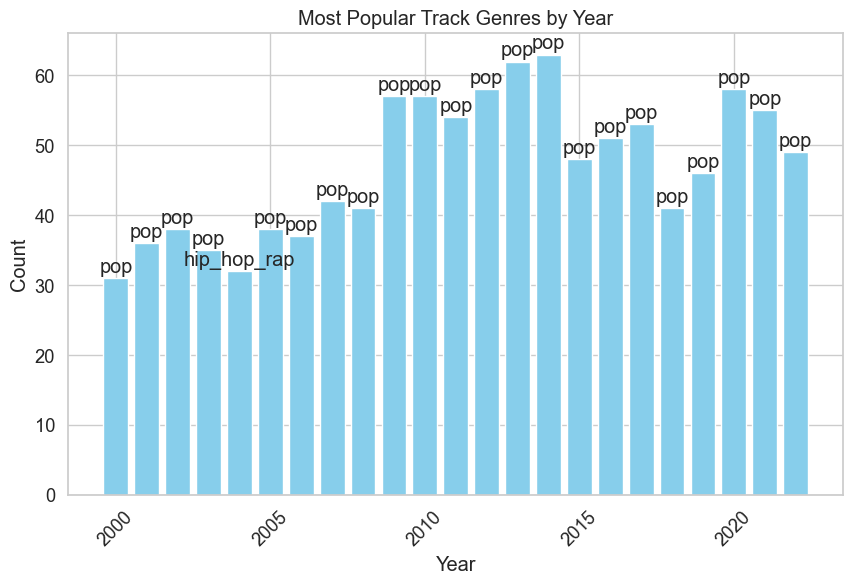

In [25]:
# Group by year and genre and count the number of tracks in each group
genre_counts = data_clean.groupby(['year', 'dominant_genre']).size().reset_index(name='counts')

# Find the most popular genre for each year
most_popular_genres = genre_counts.loc[genre_counts.groupby('year')['counts'].idxmax()]

# Plot the most popular genre for each year
plt.figure(figsize=(10, 6))
bars = plt.bar(most_popular_genres['year'], most_popular_genres['counts'], color='skyblue')
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Most Popular Track Genres by Year')

# Add genre labels to the bars
for bar, genre in zip(bars, most_popular_genres['dominant_genre']):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.3, genre, ha='center', va='bottom')

plt.xticks(rotation=45)
plt.show()

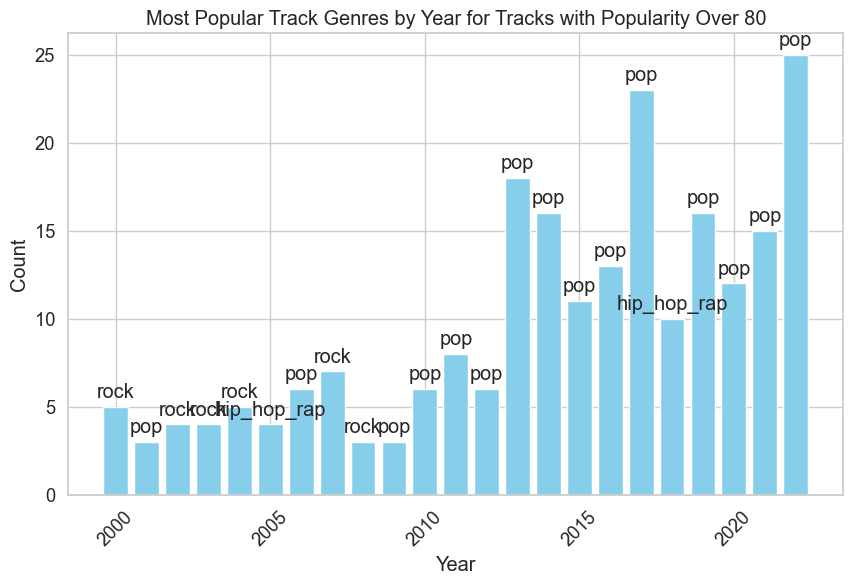

In [31]:
# Filtering by only popular track > 80

# Filter the DataFrame to only include tracks with a popularity over 80
popular_tracks = data_clean[data_clean['track_popularity'] > 80]

# Group by year and genre and count the number of tracks in each group
genre_counts = popular_tracks.groupby(['year', 'dominant_genre']).size().reset_index(name='counts')

# Find the most popular genre for each year
most_popular_genres = genre_counts.loc[genre_counts.groupby('year')['counts'].idxmax()]

# Plot the most popular genre for each year
plt.figure(figsize=(10, 6))
bars = plt.bar(most_popular_genres['year'], most_popular_genres['counts'], color='skyblue')
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Most Popular Track Genres by Year for Tracks with Popularity Over 80')

# Add genre labels to the bars
for bar, genre in zip(bars, most_popular_genres['dominant_genre']):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.3, genre, ha='center', va='bottom')

plt.xticks(rotation=45)
plt.show()

* Pop Bias: Both graphs show a strong presence of pop music across the years, suggesting a potential bias towards this genre in the dataset or in the popularity ratings.

* Genre Variability: Hip-hop/rap and rock genres fluctuate in popularity, with rock showing up only in the high popularity graph, which may indicate these genres have fewer but highly popular tracks.

* Data Representation: The consistent dominance of pop, especially in tracks with high popularity, points to a possible skew in data collection or the popularity measurement method, which favors the pop genre.

* Changing Trends: The graphs hint at evolving music trends over time, but the overwhelming prevalence of pop could mask the true diversity of music preferences.

##### Album popularity influence into track popularity   
High correlations.

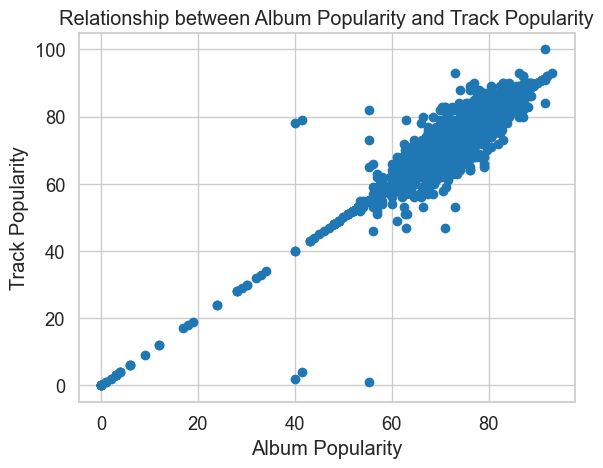

In [34]:
# Group by artist and album and calculate the mean popularity for each group
album_popularity = data_clean.groupby(['artist_name', 'album'])['track_popularity'].mean().reset_index(name='album_popularity')

# Merge the album popularity scores back into the original DataFrame
df = pd.merge(data_clean, album_popularity, on=['artist_name', 'album'], how='left')

plt.scatter(df['album_popularity'], df['track_popularity'])
plt.xlabel('Album Popularity')
plt.ylabel('Track Popularity')
plt.title('Relationship between Album Popularity and Track Popularity')
plt.show()

##### Exploring Spread on Audio Features + other numeric variables

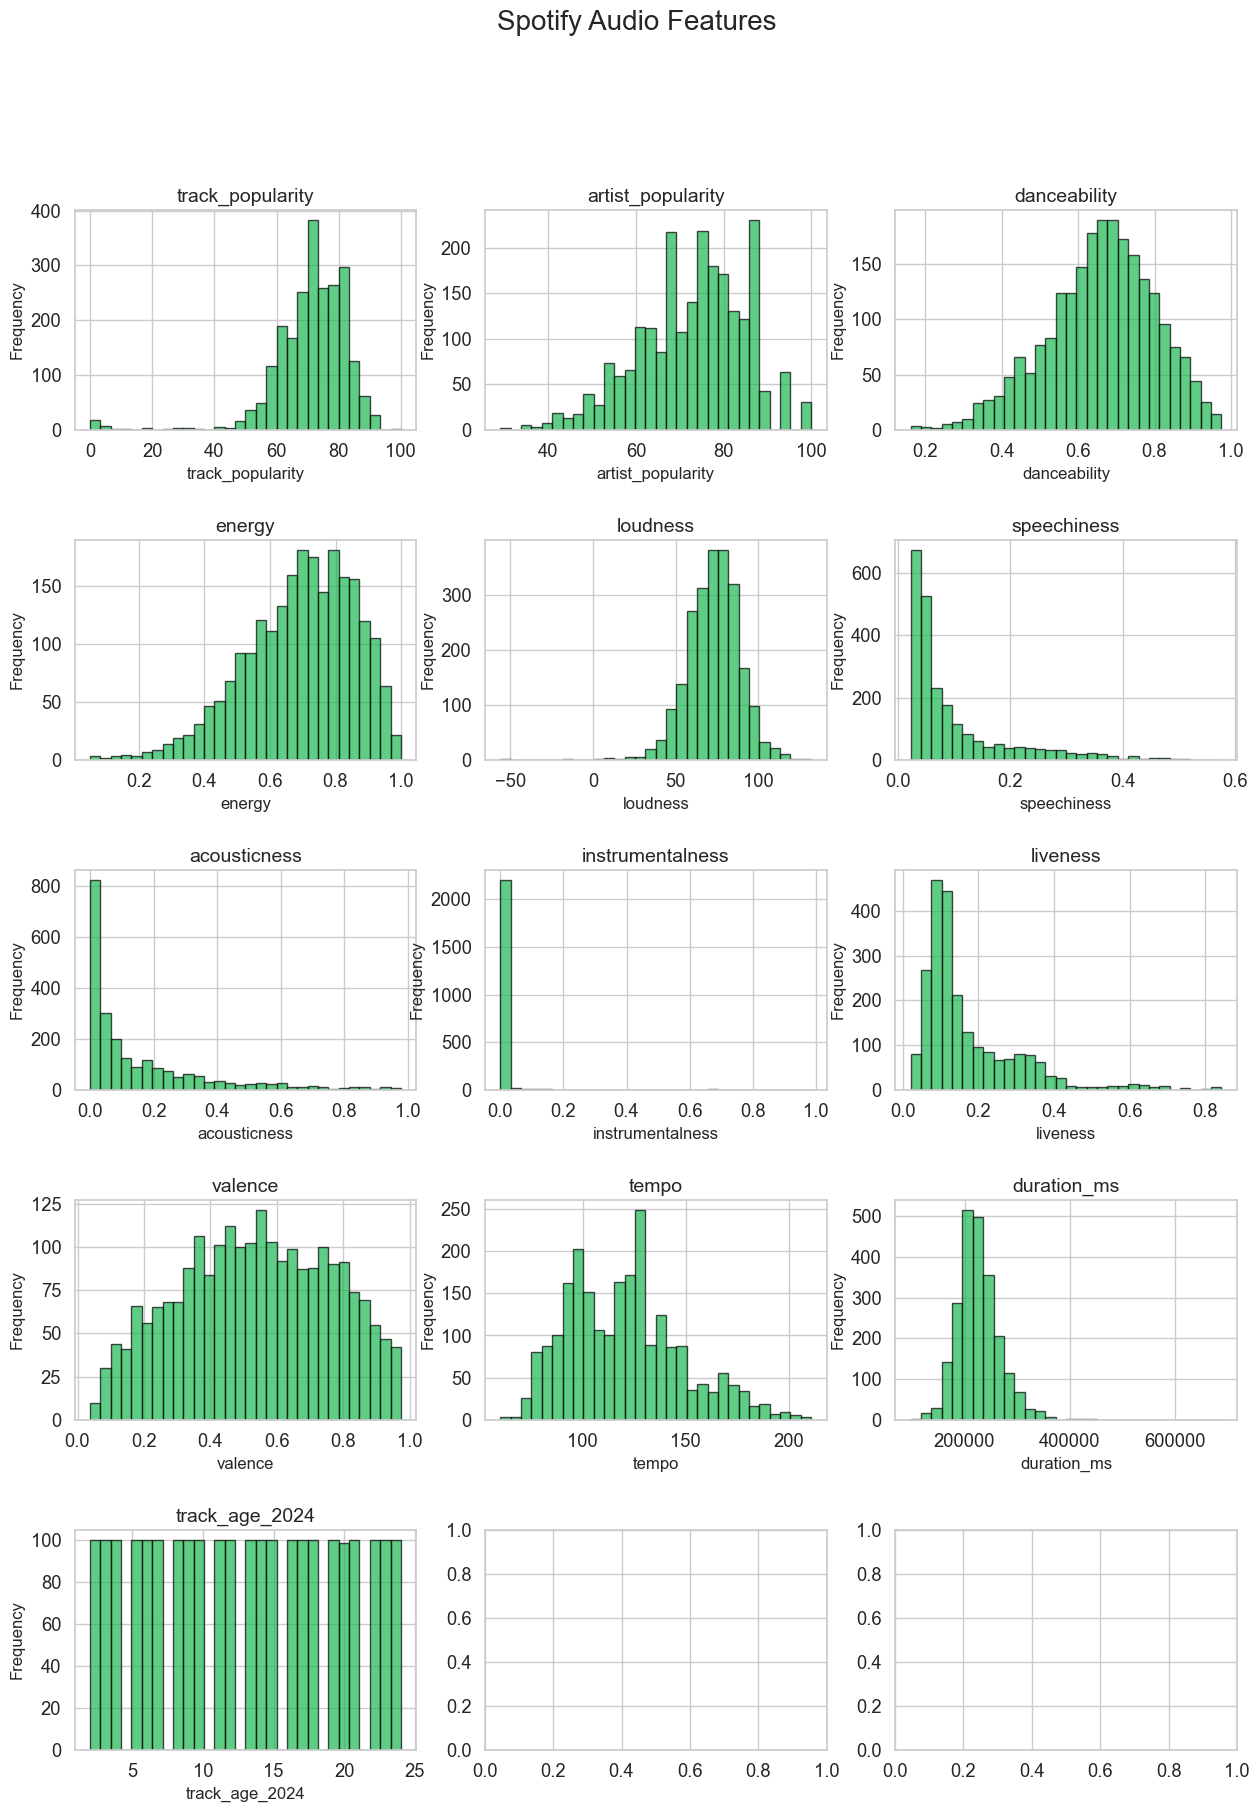

In [35]:
# Select the relevant columns from the df dataframe
hist_spotify = data_clean.select_dtypes(exclude=['object'])
hist_spotify.drop(columns=['year'], inplace=True)
# Set the figure size and layout
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 20))
fig.subplots_adjust(hspace=0.5)

# Plot histograms for each variable in the dataframe
for ax, col in zip(axes.flatten(), hist_spotify.columns):
    ax.hist(hist_spotify[col], bins=30, color='#1db954', edgecolor='black', alpha=0.7, histtype='bar')
    ax.set_title(col, fontsize=14)
    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)

# Display the plot
plt.suptitle('Spotify Audio Features', fontsize=20)
plt.show()

1. Popularity Skew: Both track and artist popularity show a left-skew with modes around 70, indicating that the dataset contains a higher number of tracks and artists that are quite popular.

2. Acoustic and Instrumental Attributes: The acousticness and instrumentalness features are heavily right-skewed, with a high frequency of tracks having low scores, suggesting that most tracks are neither acoustic nor instrumental.

3. Temporal Features Distribution: Track age in 2024 shows a multimodal distribution with peaks at regular intervals, potentially indicating a pattern in music release or data collection. The tempo of the tracks exhibits a wide distribution with a concentration of values around the 120 BPM mark, which is common for many popular music genres.

##### What makes a track popular?

[Text(0.5, 0, 'duration_ms'),
 Text(1.5, 0, 'track_popularity'),
 Text(2.5, 0, 'artist_popularity'),
 Text(3.5, 0, 'danceability'),
 Text(4.5, 0, 'energy'),
 Text(5.5, 0, 'loudness'),
 Text(6.5, 0, 'speechiness'),
 Text(7.5, 0, 'acousticness'),
 Text(8.5, 0, 'instrumentalness'),
 Text(9.5, 0, 'liveness'),
 Text(10.5, 0, 'valence'),
 Text(11.5, 0, 'tempo')]

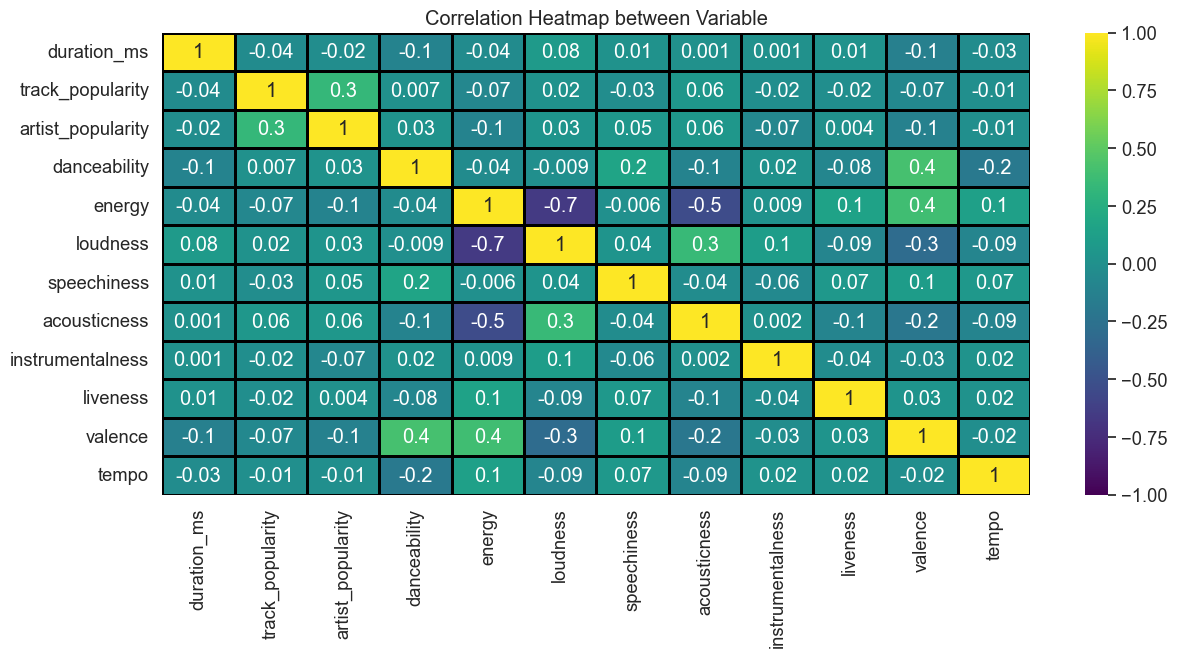

In [36]:
# Correlation Heatmap between Variable using Pearson correlation method
audio_features = data_clean[['duration_ms', 'track_popularity','artist_popularity', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']]
corr = audio_features.corr(method = 'pearson')
plt.figure(figsize=(14,6))
map = sns.heatmap(corr, annot = True, fmt = '.1g', vmin=-1, vmax=1, center=0, cmap='viridis', linewidths=1, linecolor='Black')
map.set_title('Correlation Heatmap between Variable')
map.set_xticklabels(map.get_xticklabels(), rotation=90)

From this correlation heatmap we observe:

1. Energy and Loudness: There is a strong negative correlation (0.7) between energy and loudness, suggesting that tracks with higher energy tend to be louder.

2. Danceability and Valence: Danceability and valence show a moderate positive correlation (0.4), indicating that more danceable tracks often have a more positive or cheerful mood.

3. Acousticness and Energy/Loudness: Acousticness has a moderate negative correlation with energy (-0.5) and loudness (-0.7), indicating that tracks with higher acousticness tend to be quieter and less energetic.

##### Analysis on the correlations with popularity

In [38]:
continuous_vars = data_clean.select_dtypes(include=['float64', 'int64'])
correlation_matrix = continuous_vars.corr()
correlation_with_popularity = correlation_matrix['track_popularity'].drop('track_popularity')
correlation_with_popularity


year                 0.218524
artist_popularity    0.331029
danceability         0.006881
energy              -0.074284
loudness             0.021696
speechiness         -0.027161
acousticness         0.058311
instrumentalness    -0.020854
liveness            -0.020033
valence             -0.067300
tempo               -0.013565
duration_ms         -0.043956
track_age_2024      -0.218524
Name: track_popularity, dtype: float64

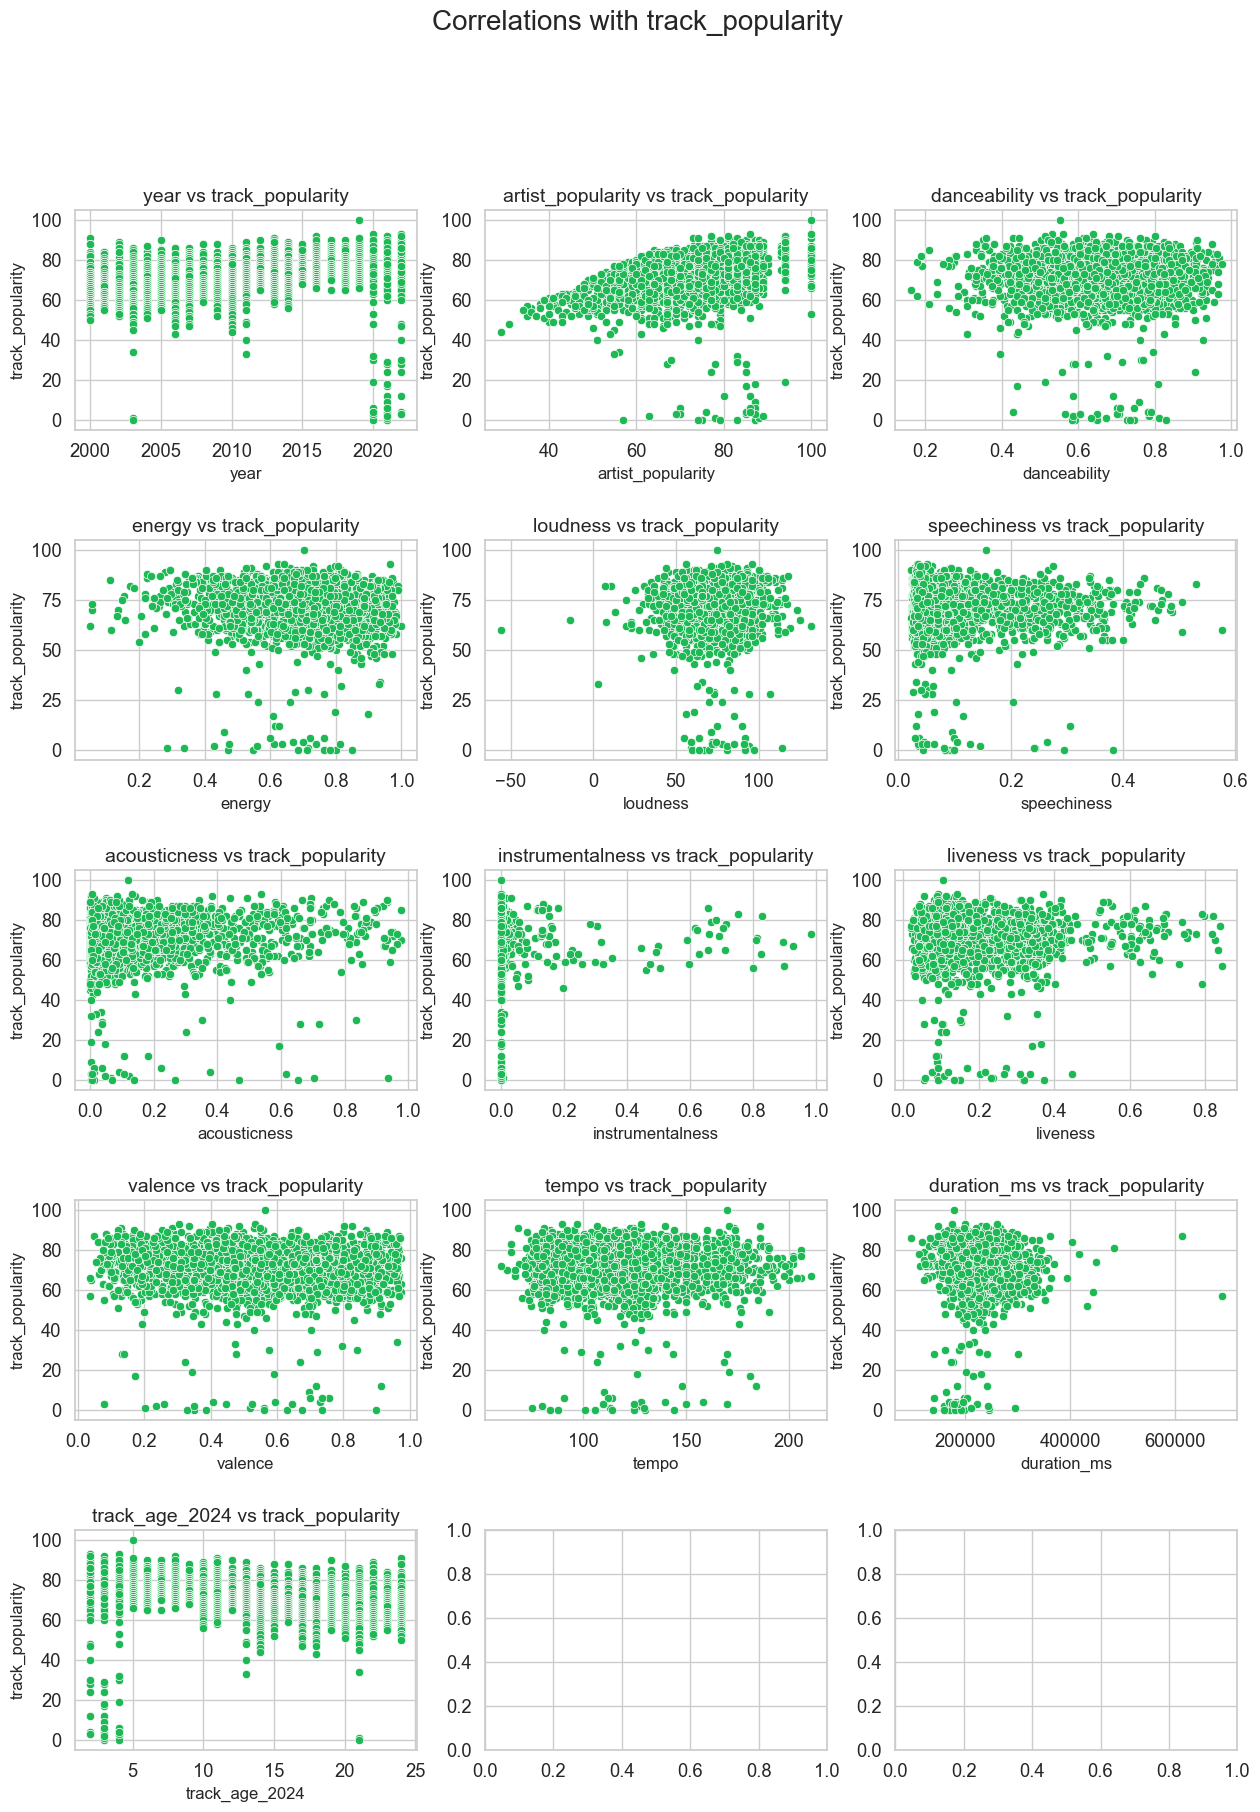

In [39]:

#plot the correlations with track_popularity in scatterplots (3 columns 5 rows)
# Select the continuous variables and calculate the correlation matrix
continuous_vars = data_clean.select_dtypes(include=['float64', 'int64'])
correlation_matrix = continuous_vars.corr()

# Get the correlations with track_popularity
correlation_with_popularity = correlation_matrix['track_popularity'].drop('track_popularity')

# Create subplots with 3 columns and 5 rows
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 20))
fig.subplots_adjust(hspace=0.5)

# Plot scatterplots for each variable with track_popularity
for ax, col in zip(axes.flatten(), correlation_with_popularity.index):
    sns.scatterplot(x=col, y='track_popularity', data=data_clean, ax=ax, color='#1db954')
    ax.set_title(f'{col} vs track_popularity', fontsize=14)
    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel('track_popularity', fontsize=12)

# Display the plot
plt.suptitle('Correlations with track_popularity', fontsize=20)
plt.show()


1. Artist Influence: There is a clear positive trend between artist popularity and track popularity, indicating that tracks by more popular artists tend to be more popular themselves.

2. Energy and Loudness: Both energy and loudness show a concentration of higher track popularity scores at higher values, suggesting that louder and more energetic tracks tend to be more popular.

3. Temporal Trends: There's no clear trend between the year or track age and track popularity, implying that track age does not necessarily predict its popularity.

### Bining Strategy (Part of Data Mining)


We've experimented with different ways to categorize our target variable, which is the popularity of a track. Since track popularity was mostly high with a few less popular exceptions, finding the right way to group these values was tricky. We aimed for categories that wouldn't lead to imbalanced data for our classifier.

Initially, we considered dividing the tracks into four categories (niche, popular, hit, classic). However, given our time constraints, creating a classifier for multiple classes proved too complex. So, we shifted our focus to a simpler binary classification.

Our first binary approach used quantiles to define what's popular or not. But we realized we were missing something important: the influence of the artist's popularity and the age of the track.

The idea was based on the observation that well-known artists are likely to boost the popularity of even their lesser-known songs. Since there was a strong correlation between artist popularity and track popularity, we used this relationship to inform our categorization, without letting it overpower our model by directly including it in training. We settled on giving a 10% weight to artist popularity in our decision, with a popularity above 70 tipping a track into the 'popular' category.

We also considered the track's age, thinking that older hits might appear less popular today than they were in their prime. But this wasn't relevant after all, as our dataset only includes tracks from the year 2000 onwards.This was attempted with the seconde function ```categorize_song_with_age_and_artist```

![Track Popularity Distribution](popularity_track_hist.png)

In [43]:
#Final Algorithm used for creating the Class
def categorize_song_artist_pop(popularity,artist_popularity, base_threshold=70, artist_weight=0.1):
    """
    Categorize song based on popularity and age.
    
    Parameters:
    - popularity: The popularity of the track.
    - age: The age of the track.
    - base_threshold: The base threshold for considering a song popular.
    - age_adjustment_rate: The number of years required for an adjustment.
    - adjustment_amount: The amount to adjust the threshold by for each age_adjustment_rate years.
    
    Returns:
    - 0 if the song is below the adjusted threshold (less popular).
    - 1 if the song is above the adjusted threshold (more popular).
    """
    # Adjust the threshold based on the age of the track
    #adjusted_threshold = base_threshold - (age // age_adjustment_rate) * adjustment_amount
     # Calculate a combined popularity score with a weighted average
    combined_popularity = (popularity * (1 - artist_weight)) + (artist_popularity * artist_weight)
    
    # Categorize the song based on the adjusted threshold
    if combined_popularity < base_threshold:
        return 0  # 'Others'
    else:
        return 1  # 'Popular'

def categorize_song_with_age_and_artist(popularity, age, artist_popularity, 
                                        base_threshold=65, age_adjustment_rate=3, 
                                        adjustment_amount=2, artist_weight=0.1):
    """
    Categorize song based on popularity, age, and artist popularity.
    
    Parameters:
    - popularity: The popularity of the track.
    - age: The age of the track.
    - artist_popularity: The popularity of the artist.
    - base_threshold: The base threshold for considering a song popular.
    - age_adjustment_rate: The number of years required for an adjustment.
    - adjustment_amount: The amount to adjust the threshold by for each age_adjustment_rate years.
    - artist_weight: The weight given to artist popularity in the final score.
    
    Returns:
    - 0 if the song is below the adjusted threshold (less popular).
    - 1 if the song is above the adjusted threshold (more popular).
    """
    # Calculate a combined popularity score with a weighted average
    combined_popularity = (popularity * (1 - artist_weight)) + (artist_popularity * artist_weight)
    
    # Adjust the threshold based on the age of the track
    adjusted_threshold = base_threshold + (age // age_adjustment_rate) * adjustment_amount
    
    # Categorize the song based on the adjusted threshold
    if combined_popularity < adjusted_threshold:
        return 0  # 'Niche'
    else:
        return 1  # 'Popular'
   
######### BASIC BINING ALGORITHM ###########   
#switch function to different cat
#data1['song_popularity_labels'] = data1.apply(lambda x: categorize_song_binary(x['track_popularity']), axis=1)
# Apply the new function to the dataset

######### Weighted Track AGE BINING ALGORITHM ###########  

data1['song_popularity_labels'] = data1.apply(lambda x: categorize_song_artist_pop(x['track_popularity'], x['artist_popularity']), axis=1)

######### Weighted Track AGE + weighted Artist Popularity BINING ALGORITHM ########### 
# Apply the new function to the dataset
#data1['song_popularity_labels'] = data1.apply(lambda x: categorize_song_with_age_and_artist(x['track_popularity'], x['track_age_2024'], x['artist_popularity']), axis=1)




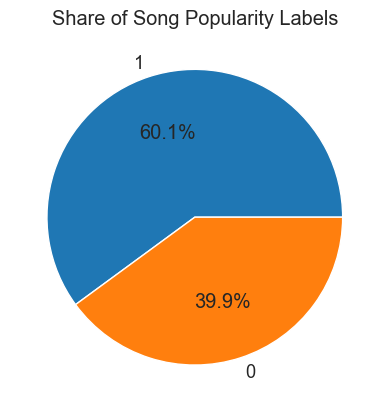

In [46]:
# Count the occurrences of each label
label_counts = data1['song_popularity_labels'].value_counts()
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%')
# Add a title
plt.title('Share of Song Popularity Labels')
# Display the chart
plt.show()


Thanks to this bining method, we have been able to split our classed in a mroe balanced way!

### One Hot Encoding

This section is about one hot encoding our categorical to the model for modeling purpoceses

In [48]:
#dummified dominant_genre
# Perform one-hot encoding
data1 = pd.get_dummies(data1, columns=['dominant_genre'], prefix_sep="_",prefix="genre",dtype=int)
# Drop a specific column
data1 = data1.drop('genre_talent show', axis=1)
print(sum(data1.columns.str.contains("genre_") == True))

#dummified tonality
data1 = pd.get_dummies(data1, columns=['tonality'],prefix_sep="_",prefix="tone",drop_first=True, dtype=int)
print(sum(data1.columns.str.contains('tone_')))

14
23


### Dimension Reduction (PCA) for Audio Features

In this section of our machine learning project, we delve into dimension reduction using Principal Component Analysis (PCA). PCA helps us condense the information contained in several original variables into a smaller set of new composite dimensions, with each representing different characteristics of the data. These new dimensions, called principal components (PCs), help us understand the underlying structure of the data and can improve the efficiency and performance of our machine learning models.

Here's a look at what each of the top five principal components represents in our dataset and some illustrative examples:

1. **Energetic and Dynamic Component (PC1)**: This component captures tracks that are full of life and vigor. Think of a track that electrifies the atmosphere, often found pulsing through the speakers of a club or energizing a workout session. An example could be Calvin Harris's "This Is What You Came For", which embodies high energy and dynamism.

2. **Speech and Tempo Component (PC2)**: Here, we find tracks where speech plays a central role, often seen in genres like hip-hop. The tempo is also an essential feature, creating a vibrant and engaging rhythm. Kendrick Lamar's "i" is a track that represents this component well, with its clear vocals and upbeat tempo.

3. **Acoustic and Speech Component (PC3)**: This component is characterized by the raw, natural sound of acoustic instruments coupled with clear vocal delivery. It’s the kind of music that might accompany a quiet evening or a reflective moment. Ed Sheeran’s "Photograph" is a great example, offering rich acoustic sounds and vocal clarity.

4. **Duration and Mood Component (PC4)**: Short and sweet – tracks that fall into this component are typically brief but leave a lasting impression of joy and positivity. Taylor Swift's "Shake It Off" is the perfect embodiment of this component, with its quick tempo and uplifting spirit.

5. **Acoustic and Liveness Component (PC5)**: Imagine a live performance where the acoustic elements and the audience's presence are palpable, capturing the essence of the moment. "In Your Atmosphere" (Live at the Nokia Theatre) by John Mayer is a track that would feature here, highlighting the authenticity and emotional connection of a live acoustic set.

By understanding these components, we can simplify the complexity of our dataset while retaining its most significant features, enabling us to build more robust model.

In [49]:
audio_features = ['danceability', 'energy',
       'loudness', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'duration_ms']

pca_data = data1[audio_features]

ss = StandardScaler().fit(pca_data)
X_std = ss.transform(pca_data)

sklearn_pca = PCA()
Y_sklearn = sklearn_pca.fit_transform(X_std)

VARIANCE_TO_KEEP = 0.75
keep_recommend = [sklearn_pca.explained_variance_ratio_[:y].sum()>VARIANCE_TO_KEEP for y in range(1,sklearn_pca.n_components_+1)].count(False)
print("Number of components to keep to retain %s%% of the variance:" % (100*VARIANCE_TO_KEEP), keep_recommend, "out of the original", sklearn_pca.n_components_)
retained_components_number = keep_recommend

sklearn_pca_final = PCA(n_components=retained_components_number)
Y_sklearn_final = sklearn_pca_final.fit_transform(X_std)

data1_PCA = pd.concat([data1, pd.DataFrame(Y_sklearn_final[:, :5], columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])], axis=1)
data1_PCA.rename(columns={'PC1': 'PC1_Energetic_Dynamic', 'PC2': 'PC2_Speech_Tempo', 'PC3': 'PC3_Acoustic_Speech', 'PC4': 'PC4_Duration_Mood ', 'PC5': 'PC5_Acoustic_Liveness'}, inplace=True)
data1_PCA.head()

Number of components to keep to retain 75.0% of the variance: 5 out of the original 10


,year,track_name,track_popularity,album,artist_name,artist_genres,artist_popularity,danceability,energy,key,...,tone_Fmin,tone_G#Maj,tone_G#min,tone_GMaj,tone_Gmin,PC1_Energetic_Dynamic,PC2_Speech_Tempo,PC3_Acoustic_Speech,PC4_Duration_Mood,PC5_Acoustic_Liveness
0,2000.0,Yellow,91.0,Parachutes,Coldplay,"[permanent wave, pop]",86.0,0.429,0.661,B,...,0.0,0.0,0.0,0.0,0.0,0.697489,2.681419,-0.475313,0.575820,0.265080
1,2000.0,All The Small Things,84.0,Enema Of The State,blink-182,"[alternative metal, modern rock, pop punk, pun...",75.0,0.434,0.897,C,...,0.0,0.0,0.0,0.0,0.0,-1.863289,2.037136,-0.917177,0.337012,-0.962087
2,2000.0,Breathe,69.0,Breathe,Faith Hill,"[contemporary country, country, country dawn, ...",61.0,0.529,0.496,G,...,0.0,0.0,0.0,1.0,0.0,1.955014,1.289486,-0.361391,-0.056666,0.118168
3,2000.0,In the End,88.0,Hybrid Theory (Bonus Edition),Linkin Park,"[alternative metal, nu metal, post-grunge, rap...",83.0,0.556,0.864,D#,...,0.0,0.0,0.0,0.0,0.0,-0.464720,0.915760,0.304314,-0.611131,0.001659
4,2000.0,Bye Bye Bye,74.0,No Strings Attached,*NSYNC,"[boy band, dance pop, pop]",65.0,0.610,0.926,G#,...,0.0,0.0,1.0,0.0,0.0,-1.901801,0.609784,0.664915,1.312768,-0.747559


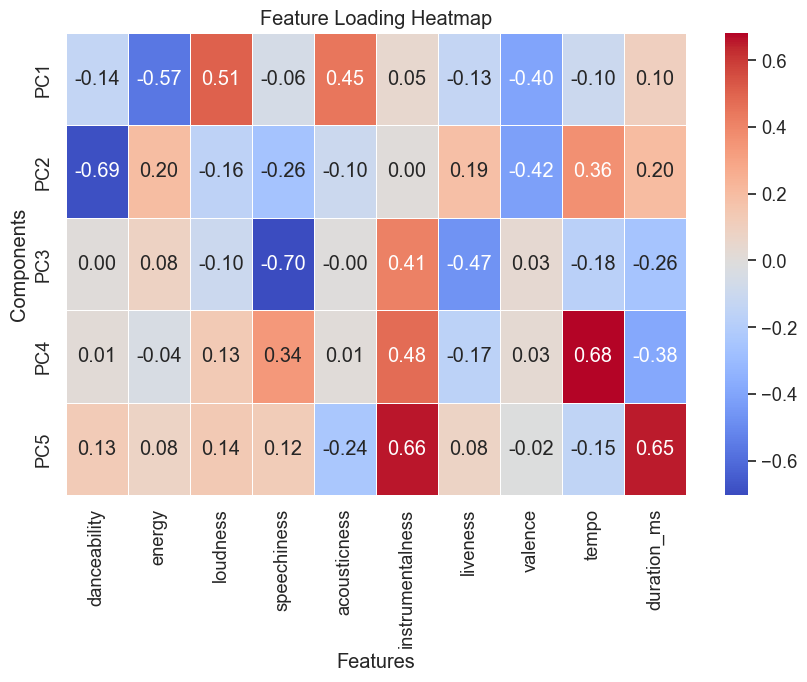

In [51]:

feature_names = pca_data.columns
component_names = [f"PC{i+1}" for i in range(retained_components_number)]

feature_loading_table = pd.DataFrame(sklearn_pca_final.components_, columns=feature_names, index=component_names)
feature_loading_table

plt.figure(figsize=(10, 6))
sns.heatmap(feature_loading_table, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)
plt.title('Feature Loading Heatmap')
plt.xlabel('Features')
plt.ylabel('Components')
plt.show()


In [52]:
#rename index
data1_PCA = data1_PCA.rename_axis("song_id")
data1_PCA.columns

Index(['year', 'track_name', 'track_popularity', 'album', 'artist_name',
       'artist_genres', 'artist_popularity', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'duration_ms', 'track_age_2024',
       'song_popularity_labels', 'genre_country', 'genre_folk',
       'genre_hip_hop_rap', 'genre_house_and_pop_fusion', 'genre_jazz',
       'genre_latin', 'genre_metal', 'genre_other', 'genre_pop',
       'genre_reggae', 'genre_rnb_soul', 'genre_rock',
       'genre_singer-songwriter', 'genre_underground_electronic', 'tone_A#min',
       'tone_AMaj', 'tone_Amin', 'tone_BMaj', 'tone_Bmin', 'tone_C#Maj',
       'tone_C#min', 'tone_CMaj', 'tone_Cmin', 'tone_D#Maj', 'tone_D#min',
       'tone_DMaj', 'tone_Dmin', 'tone_EMaj', 'tone_Emin', 'tone_F#Maj',
       'tone_F#min', 'tone_FMaj', 'tone_Fmin', 'tone_G#Maj', 'tone_G#min',
       'tone_GMaj', 'tone_Gmin', 'PC1_Energetic_Dynamic', 'PC2_Spee

In [ ]:
# download data in csv
#data1_PCA.to_csv("./data_cleaned_final_PCA.csv")

## MODELING

In the model development phase of our analysis, we've employed a variety of machine learning algorithms to find the best performer for our dataset. To ensure that we're getting the most out of each model, we've used grid search—a method of hyperparameter optimization—to fine-tune the models. This process involves testing different combinations of parameters to find the most optimal settings for each model. We've validated these settings using 5-fold cross-validation, which helps to assess the model's effectiveness and prevent overfitting by dividing the data into five parts, training on four, and validating on the fifth.

Here's a list of the models we've fine-tuned and are evaluating:

* __Logistic Regression__: A straightforward and efficient model for binary classification tasks.
* __Decision Tree: A model__: that splits the data into branches to make predictions, offering easy interpretability.
* __Bagging__: Short for Bootstrap Aggregating, this technique combines the results of multiple decision trees to improve stability and accuracy.
* __Random Forest__: An ensemble of decision trees, which improves predictive performance by reducing overfitting.
* __XGBOOST__: An implementation of gradient boosted decision trees designed for speed and performance.
* __AdaBoost__: A boosting algorithm that adjusts the weights of the classifier and the training data to minimize errors.
* __Gaussian Naive Bayes__: A probabilistic classifier based on applying Bayes' theorem with the assumption of feature independence.  

Each of these models brings its own strengths to the table, and through fine-tuning, we aim to capitalize on these strengths to achieve the best predictive performance for our task.



#### Train Test Split:

Throughout this phase, we cured our preprocessed dataset in order to start our modeling process.

* Drop unnecessary columns for training
* Design Train Test Split

In [290]:
data = data1_PCA
cols_to_drop = ['year', 'track_name', 'album', 'artist_name','mode', 'key',
       'artist_genres', 'track_popularity',
       
       ] #,,'track_popularity','track_age_2024', 'artist_popularity'
data = data.drop(columns = cols_to_drop)
data.columns

Index(['artist_popularity', 'danceability', 'energy', 'loudness',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'track_age_2024',
       'song_popularity_labels', 'genre_country', 'genre_folk',
       'genre_hip_hop_rap', 'genre_house_and_pop_fusion', 'genre_jazz',
       'genre_latin', 'genre_metal', 'genre_other', 'genre_pop',
       'genre_reggae', 'genre_rnb_soul', 'genre_rock',
       'genre_singer-songwriter', 'genre_underground_electronic', 'tone_A#min',
       'tone_AMaj', 'tone_Amin', 'tone_BMaj', 'tone_Bmin', 'tone_C#Maj',
       'tone_C#min', 'tone_CMaj', 'tone_Cmin', 'tone_D#Maj', 'tone_D#min',
       'tone_DMaj', 'tone_Dmin', 'tone_EMaj', 'tone_Emin', 'tone_F#Maj',
       'tone_F#min', 'tone_FMaj', 'tone_Fmin', 'tone_G#Maj', 'tone_G#min',
       'tone_GMaj', 'tone_Gmin', 'PC1_Energetic_Dynamic', 'PC2_Speech_Tempo',
       'PC3_Acoustic_Speech', 'PC4_Duration_Mood ', 'PC5_Acoustic_Liveness'],
      dtype='obj

In [291]:
df = data.copy()
#drop 2 null rows ==> TO BE CHECKED
#df.drop(index=[2299,447], inplace=True)
df.fillna(0, inplace=True)
seed = 477
acc="accuracy" # our metric for Grid Searching
PCA_Data = df.drop(columns=audio_features)
Data = df.loc[:, ~df.columns.str.contains('PC_')]

In [292]:
def split_df(dataframe, seed=None ,percentage=0.7):
    
    X = dataframe.loc[:, dataframe.columns != 'song_popularity_labels']
    y = dataframe['song_popularity_labels']

    return train_test_split(X, y, test_size=1-percentage, random_state=seed, stratify=y) # note the stratify parameter

In [293]:
# train_test_split
X_train, X_test, Y_train, Y_test = split_df(PCA_Data, seed=seed, percentage=0.7)
print("Number of explanatories: ", len(PCA_Data.columns)-1)

Number of explanatories:  44


#### Functions for Model Performances

In [294]:
# Function to print Confusion Matrix and Classification Report
# df_cm, df_perf = model_perf(titanic_tree_pruned, Y_test, predictions, "Classification Tree", df_cm, df_perf, plot = True)


def model_perf(model, Y_test, Y_predict, algorithm, df_cm, df_perf, ax=None, plot = True):
    # confusion_matrix
    conf_mat = confusion_matrix(Y_test, Y_predict)
    
    # get accuracy of model
    acc_score = accuracy_score(Y_test, Y_predict)
    print(f"Accuracy of {algorithm} for Test data is {acc_score*100}\n")

    # get F1-score of model
    f1score = f1_score(Y_test, Y_predict) 
    print(f"F1-score of {algorithm} for Test data is {f1score*100}\n")
    
    # get the classification report
    class_report = classification_report(Y_test, Y_predict)
    print(f"Classification report for {algorithm} is: \n {class_report}")
    
    # AUC Calculations - false positive rates, true positive rates and thresholds
    fpr, tpr, thresholds = roc_curve(Y_test, Y_predict, pos_label=1)
    
    #area_under_curve
    roc_auc = round(auc(fpr, tpr)*100,2)
    print(f"AUC for {algorithm}: {roc_auc}\n")
    
    #Train Accuracy score
    train_acc = round(model.score(X_train,Y_train) * 100,2)

    #Test Accuracy score
    test_acc = round(model.score(X_test,Y_test) * 100,2)

    precision,recall,fscore,support = precision_recall_fscore_support(Y_test,Y_predict)

    #Appending into the dataframe
    newrow_perf= pd.DataFrame({'Model' : [algorithm],'Train Accuracy' : [train_acc],'Test Accuracy' : [test_acc],
                          'F1-Score' : [fscore[1]],'Recall' : [recall[1]], 'Precision' : [precision[1]], 'AUC' : [roc_auc]})
    
    df_perf = pd.concat([df_perf, newrow_perf], ignore_index=True)

    
    newrow_cm= pd.DataFrame({"Model" : [algorithm], "True Positives" : [conf_mat[1][1]], "True Negatives" : [conf_mat[0][0]],
                             "False Positives" : [conf_mat[0][1]], "False Negatives" : [conf_mat[1][0]]})
                            
    df_cm = pd.concat([df_cm, newrow_cm], ignore_index=True, sort=False)

##########################################--PLOT---###########################################
    if plot:
        def conf_plot1(ax = None):
            if ax is None:
                fig, ax = plt.subplots()
            # For label annotations in confusion_matrix
            label_names = ['True N','False N','False P','True P']
            label_counts = ['{0:0.0f}'.format(value) for value in conf_mat.flatten()]
            labels = [f'{v1}\n{v2}' for v1, v2 in zip(label_names,label_counts)]
            labels = np.asarray(labels).reshape(2,2)

            # Draw heatmap using confusion matrix
            sns.heatmap(conf_mat, annot=labels, fmt='')
            ax.set_xlabel('Actual Values')
            ax.set_ylabel('Predicted Values')
            #ax.show()

        #Line plot for ROC curve using fpr and tpr value
        def roc_plot2(ax = None):
            if ax is None:
                fig, ax = plt.subplots()
            ax.plot(fpr, tpr, color='red', label = 'AUC = %0.3f' % roc_auc)  
            ax.set_title('Receiver Operating Characteristic (ROC)')    
            ax.legend(loc = 'lower right')
            ax.plot([0, 1], [0, 1],linestyle='--') #Intersection line
            ax.set_xlabel('False Positive Rate')
            ax.set_ylabel('True Positive Rate')
            ax.set_xlim([0,1])
            ax.set_ylim([0,1])
            ax.set_xticks([i for i in np.arange(0,1.1,0.1)])
            ax.set_yticks([i for i in np.arange(0,1.1,0.1)])
        
        prec, rec, thres = precision_recall_curve(Y_test, Y_predict)
        prec, rec, thres = prec.tolist(), rec.tolist(), thres.tolist()
        prec.pop()
        rec.pop()
            
        def rec_plot3(ax = None):
            if ax is None:
                fig, ax = plt.subplots()
            #Plot Precision-Recall curve
            fig, axis = (None, ax) if ax else plt.subplots()
            axis_twin = axis.twinx()

            #Threshold vs Precision
            sns.lineplot(x = thres, y = prec, label='Precision', ax=axis)
            axis.set_xlabel('Threshold')
            axis.set_ylabel('Precision')
            axis.legend(loc='lower left')

            #Threshold vs Recall
            sns.lineplot(x = thres, y = rec, color='limegreen', label='Recall', ax=axis_twin)
            axis_twin.set_ylabel('Recall')
            axis_twin.set_ylim(0, 1)
            axis_twin.legend(bbox_to_anchor=(0.32, 0.20),loc='lower right')

            axis.set_xlim(0, 1)
            axis.set_ylim(0, 1)
            axis.set_title('Precision Vs Recall')
        
                    
        fig = plt.figure(figsize = (15,4))
        ax1 = fig.add_subplot(1,3,1)
        conf_plot1(ax1)
        ax2 = fig.add_subplot(1,3,2)
        roc_plot2(ax2)
        axis = fig.add_subplot(1,3,3)
        rec_plot3(axis)
    
    
    return df_cm, df_perf

In [295]:
# Dataframe to store Model Performance Results
perf_cols = ['Model','Train Accuracy','Test Accuracy','F1-Score','Recall','Precision', 'AUC']
df_perf = pd.DataFrame(columns = perf_cols)

# DataFrame for Confusion matrix
conf_mat_cols = ['Model','False Negatives','False Positives','True Negatives','True Positives']
df_cm = pd.DataFrame(columns = conf_mat_cols)

# DataFrame for cross validation scores
cv_cols = ['Model','Best_Cross_Val_Score']
df_cv = pd.DataFrame(columns = cv_cols)

#### Starting Runing with different Models

##### Logistic Regression

Training Accuracy: 76.382846%
Accuracy of Log PCA for Test data is 75.68740955137481

F1-score of Log PCA for Test data is 80.77803203661327

Classification report for Log PCA is: 
               precision    recall  f1-score   support

         0.0       0.73      0.62      0.67       276
         1.0       0.77      0.85      0.81       415

    accuracy                           0.76       691
   macro avg       0.75      0.73      0.74       691
weighted avg       0.75      0.76      0.75       691

AUC for Log PCA: 73.33



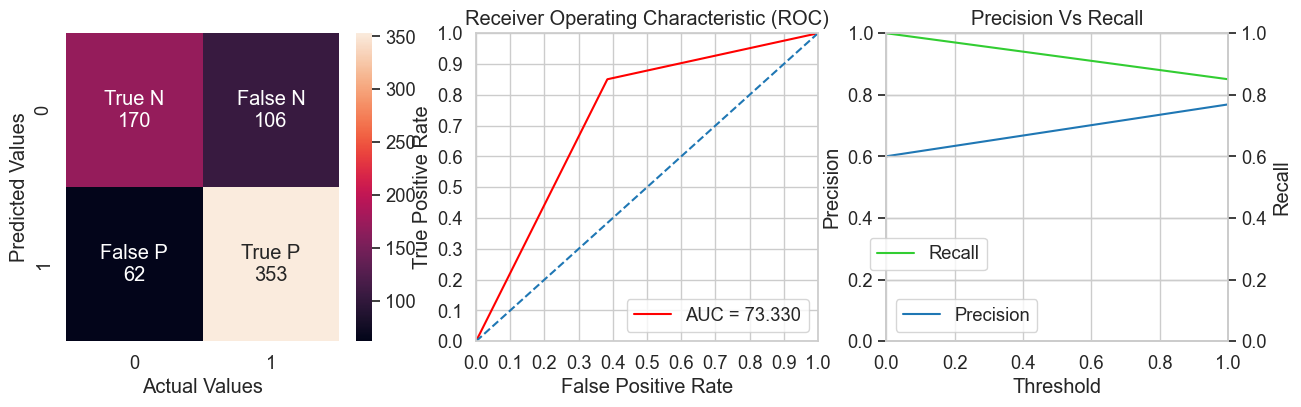

In [296]:
from sklearn.linear_model import LogisticRegression
log_reg_PCA = LogisticRegression()
log_reg_PCA.fit(X_train, Y_train)
predictions_log_PCA = log_reg_PCA.predict(X_test)
class_report_PCA_Logit = classification_report(Y_test, predictions_log_PCA)

# Assuming model is your trained model and X_train, Y_train are your training data and labels
train_accuracy_log = log_reg_PCA.score(X_train, Y_train)

print(f'Training Accuracy: {train_accuracy_log * 100:.6f}%')


acc_log = accuracy_score(Y_test, predictions_log_PCA)
f1_Log_PCA = f1_score(Y_test,predictions_log_PCA, average='weighted')
precision_Log_PCA = precision_score(Y_test, predictions_log_PCA, average='weighted')
recall_Log_PCA = recall_score(Y_test, predictions_log_PCA, average='weighted')

df_cm_log, df_perf_log = model_perf(log_reg_PCA, Y_test, predictions_log_PCA, "Log PCA", df_cm, df_perf, plot = True)

Based on the results for the Logistic Regression model, here are the three key points:

- The Logistic Regression model achieved a training accuracy of approximately 76.38% and a slightly lower test accuracy of around 75.69%, indicating a consistent performance from training to unseen data.
- The model's weighted F1-score for the test data is 75%, which is relatively high, suggesting a good balance between precision and recall, particularly for the positive class (labeled as "1").
- The AUC (Area Under the Curve) for the model is 73.33%, which is a respectable score indicating a decent level of separability between the classes. However, there is room for improvement, as seen in the Receiver Operating Characteristic (ROC) curve, which shows some distance from the top-left corner.

##### Decision Tree

Fitting 5 folds for each of 15 candidates, totalling 75 fits


Best param:  {'max_depth': 2}
Training Accuracy: 76.382846%
Accuracy of Test set (pruned) = 75.69%
Accuracy of DT PCA for Test data is 75.68740955137481

F1-score of DT PCA for Test data is 80.9090909090909

Classification report for DT PCA is: 
               precision    recall  f1-score   support

         0.0       0.74      0.61      0.67       276
         1.0       0.77      0.86      0.81       415

    accuracy                           0.76       691
   macro avg       0.75      0.73      0.74       691
weighted avg       0.75      0.76      0.75       691

AUC for DT PCA: 73.15



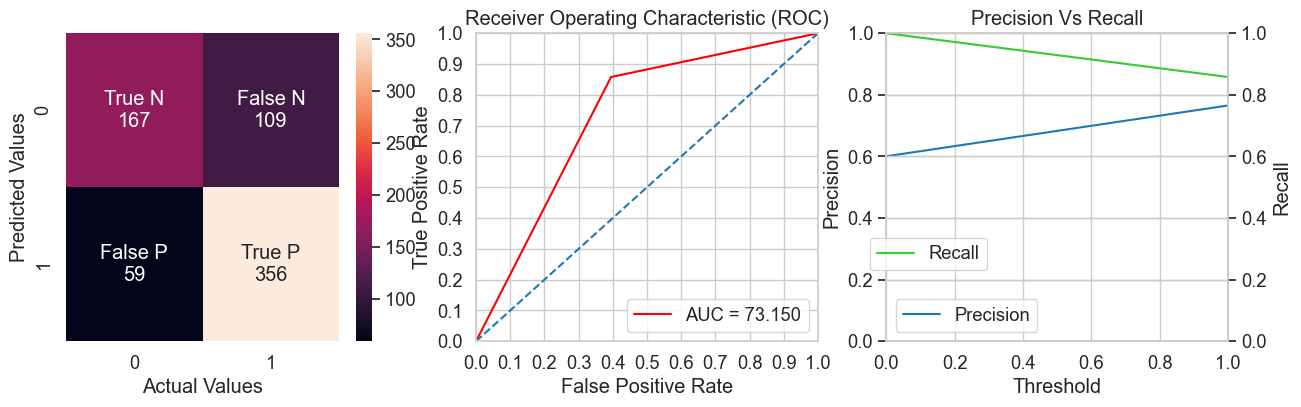

In [297]:

decision_tree = DecisionTreeClassifier()
param_grid = {
    'max_depth': range(1,16)
    } 

tree_grid = GridSearchCV(decision_tree, param_grid, scoring=acc, cv=5 , n_jobs=1, verbose=1)
tree_grid.fit(X_train,Y_train)
print("Best param: ", tree_grid.best_params_)
tree_pruned = DecisionTreeClassifier(max_depth=tree_grid.best_params_["max_depth"], criterion="entropy")
tree_pruned.fit(X_train, Y_train)

train_accuracy_DT = tree_pruned.score(X_train, Y_train)
print(f'Training Accuracy: {train_accuracy_log * 100:.6f}%')

predictions_DT_G = tree_pruned.predict(X_test)
accDTGrid=accuracy_score(Y_test, predictions_DT_G)
print("Accuracy of Test set (pruned) = {0:.2%}".format(accDTGrid))

f1_TreeGrid = f1_score(Y_test,predictions_DT_G, average='weighted')
precision_TreeGrid = precision_score(Y_test, predictions_DT_G, average='weighted')
recall_TreeGrid = recall_score(Y_test, predictions_DT_G, average='weighted')

class_report_Decision_Tree_Grid = classification_report(Y_test, predictions_DT_G)
df_cm_dt, df_perf_dt = model_perf(tree_pruned, Y_test, predictions_DT_G, "DT PCA", df_cm, df_perf, plot = True)

Based on the results for the Decision Tree model, here are the three key points:

- The Decision Tree model has a similar training and test accuracy as the Logistic Regression model, both around 76%, and an F1-score for the test data of approximately 80.91%, which indicates a good balance between precision and recall for this model as well.
- The AUC of 73.15% for the Decision Tree is slightly lower than that of the Logistic Regression, implying a comparable ability to differentiate between the classes, but still indicating some room for improvement.
- The Decision Tree model seems to have a marginally better recall for the positive class (labeled as "1") compared to Logistic Regression, suggesting it may be slightly more sensitive to detecting the positive instances.

##### Bagging

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END .................................min_samples_leaf=3; total time=   0.4s
[CV] END .................................min_samples_leaf=3; total time=   0.4s
[CV] END .................................min_samples_leaf=3; total time=   0.4s
[CV] END .................................min_samples_leaf=3; total time=   0.4s
[CV] END .................................min_samples_leaf=3; total time=   0.4s
[CV] END .................................min_samples_leaf=4; total time=   0.4s
[CV] END .................................min_samples_leaf=4; total time=   0.4s
[CV] END .................................min_samples_leaf=4; total time=   0.4s
[CV] END .................................min_samples_leaf=4; total time=   0.4s
[CV] END .................................min_samples_leaf=4; total time=   0.4s
[CV] END .................................min_samples_leaf=5; total time=   0.4s
[CV] END .................................min_sam

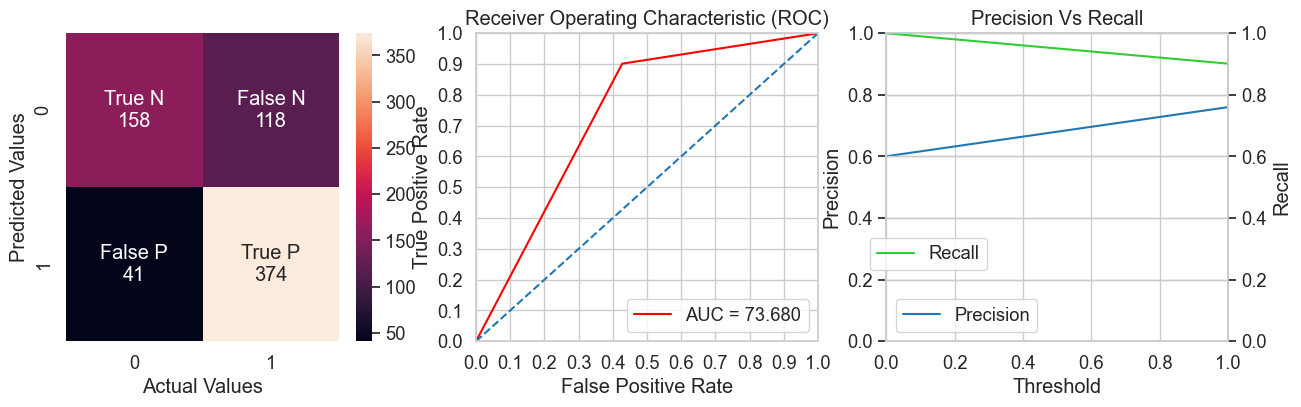

In [298]:
param_grid = {'min_samples_leaf' :[3,4,5,6,7]}
bagging = RandomForestClassifier(n_estimators=200, oob_score=True)
BaggGrid = GridSearchCV(bagging, param_grid=param_grid, cv=5, scoring=acc, verbose=2) 
BaggGrid.fit(X_train,Y_train)
print("Best param: ", BaggGrid.best_params_)
model = RandomForestClassifier(n_estimators = 200, oob_score = True,
                               min_samples_leaf = BaggGrid.best_params_["min_samples_leaf"])
model.fit(X_train,Y_train)

train_accuracy_Bagg = model.score(X_train, Y_train)
print(f'Training Accuracy: {train_accuracy_log * 100:.6f}%')

predictions_bagg_G = model.predict(X_test)
accBaggGrid=model.oob_score_
print("Accuracy OOB set - Bagging with Grid Searching: {0:.2%}".format(accBaggGrid))

f1_BaggGrid = f1_score(Y_test,predictions_bagg_G, average='weighted')
precision_BaggGrid = precision_score(Y_test, predictions_bagg_G, average='weighted')
recall_BaggGrid = recall_score(Y_test, predictions_bagg_G, average='weighted')

class_report_Bagging_Grid = classification_report(Y_test, predictions_bagg_G)
print(class_report_Bagging_Grid)

df_cm_bag, df_perf_bag = model_perf(BaggGrid, Y_test, predictions_bagg_G, "BaggGrid PCA", df_cm, df_perf, plot = True)

Here are the three key points from the Bagging model's results:

- The Bagging model shows an overall accuracy of 77%, which is slightly higher than the individual Decision Tree and Logistic Regression models, indicating a potential improvement by aggregating the predictions of multiple models.
- The model has achieved a weighted F1-score of 76% for the positive class, reflecting a strong ability to correctly classify the majority class while maintaining a balance between precision and recall.
- With an AUC of 73.68%, the Bagging model demonstrates a comparable discriminative ability as the previous models, suggesting that the ensemble method is capturing the underlying patterns in the data effectively.

##### Random Forest

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END .................max_features=7, min_samples_leaf=3; total time=   0.4s
[CV] END .................max_features=7, min_samples_leaf=3; total time=   0.4s
[CV] END .................max_features=7, min_samples_leaf=3; total time=   0.4s
[CV] END .................max_features=7, min_samples_leaf=3; total time=   0.4s
[CV] END .................max_features=7, min_samples_leaf=3; total time=   0.4s
[CV] END .................max_features=7, min_samples_leaf=4; total time=   0.4s
[CV] END .................max_features=7, min_samples_leaf=4; total time=   0.4s
[CV] END .................max_features=7, min_samples_leaf=4; total time=   0.4s
[CV] END .................max_features=7, min_samples_leaf=4; total time=   0.4s
[CV] END .................max_features=7, min_samples_leaf=4; total time=   0.4s
[CV] END .................max_features=7, min_samples_leaf=5; total time=   0.4s
[CV] END .................max_features=7, min_s

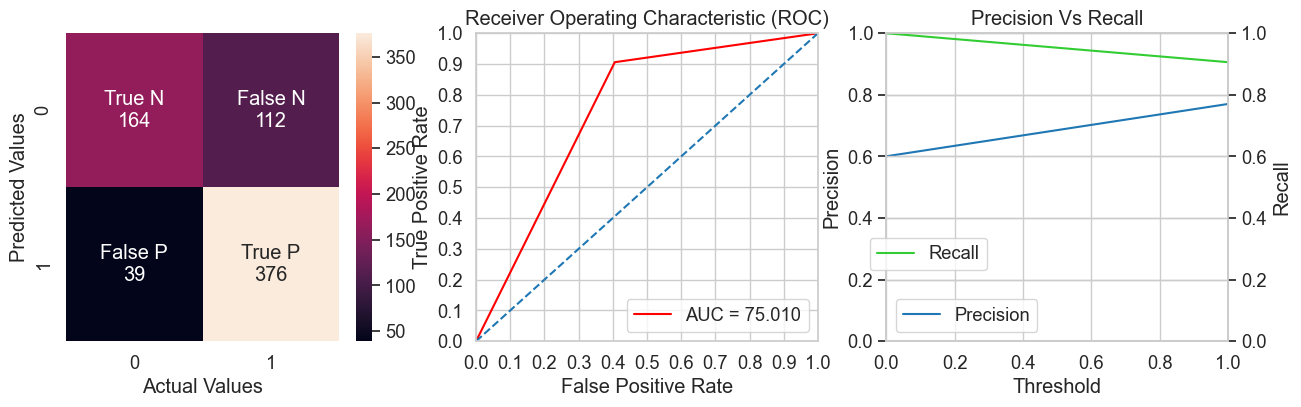

In [299]:
param_grid = {
    'min_samples_leaf' :[3,4,5,6], 
    'max_features' : [7,10,15,20,25,30],
}
RandomForest = RandomForestClassifier(n_estimators=200, oob_score=True) #
RFGrid = GridSearchCV(RandomForest, param_grid=param_grid, cv=5, scoring=acc, verbose=2) 
RFGrid.fit(X_train,Y_train)
print("Best param: ", RFGrid.best_params_)
model = RandomForestClassifier(n_estimators=200, oob_score=True, 
                               max_features=RFGrid.best_params_["max_features"], 
                               min_samples_leaf=RFGrid.best_params_["min_samples_leaf"])
model.fit(X_train,Y_train)

train_accuracy_RF = model.score(X_train, Y_train)
print(f'Training Accuracy: {train_accuracy_log * 100:.6f}%')

accRFGrid=model.oob_score_
print("Accuracy OOB set - RF with Grid Searching: {0:.2%}".format(accRFGrid))

predictions_RF_G = model.predict(X_test)


f1_RFGrid = f1_score(Y_test,predictions_RF_G, average='weighted')
precision_RFGrid = precision_score(Y_test, predictions_RF_G, average='weighted')
recall_RFGrid = recall_score(Y_test, predictions_RF_G, average='weighted')

class_report_RandomForest_Grid = classification_report(Y_test, predictions_RF_G)
print(class_report_RandomForest_Grid)

df_cm_rf, df_perf_rf = model_perf(model, Y_test, predictions_RF_G, "RF PCA", df_cm, df_perf, plot = True)

Here are the three key points from the Random Forest model's results:

- The Random Forest model shows an improved test accuracy of approximately 78.15% and a weighted F1-score of 77% for the test data, which suggests that the ensemble method is effectively capturing the complex patterns in the data.
- The model's AUC is 75.01%, indicating a better performance in distinguishing between classes compared to the previous models we've seen, which could be due to Random Forest's ability to handle a large number of input variables and find nonlinear relationships.
- The confusion matrix and the ROC curve suggest that the Random Forest model has a strong ability to correctly predict the positive class while maintaining a reasonable error rate, as indicated by the number of true positives and the shape of the ROC curve.

##### XGBOOST

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END ....learning_rate=0.001, max_depth=3, subsample=0.6; total time=   0.2s
[CV] END ....learning_rate=0.001, max_depth=3, subsample=0.6; total time=   0.1s
[CV] END ....learning_rate=0.001, max_depth=3, subsample=0.6; total time=   0.1s
[CV] END ....learning_rate=0.001, max_depth=3, subsample=0.6; total time=   0.1s
[CV] END ....learning_rate=0.001, max_depth=3, subsample=0.6; total time=   0.1s
[CV] END ....learning_rate=0.001, max_depth=3, subsample=0.8; total time=   0.1s
[CV] END ....learning_rate=0.001, max_depth=3, subsample=0.8; total time=   0.1s
[CV] END ....learning_rate=0.001, max_depth=3, subsample=0.8; total time=   0.1s
[CV] END ....learning_rate=0.001, max_depth=3, subsample=0.8; total time=   0.1s
[CV] END ....learning_rate=0.001, max_depth=3, subsample=0.8; total time=   0.1s
[CV] END ....learning_rate=0.001, max_depth=3, subsample=1.0; total time=   0.1s
[CV] END ....learning_rate=0.001, max_depth=3, 

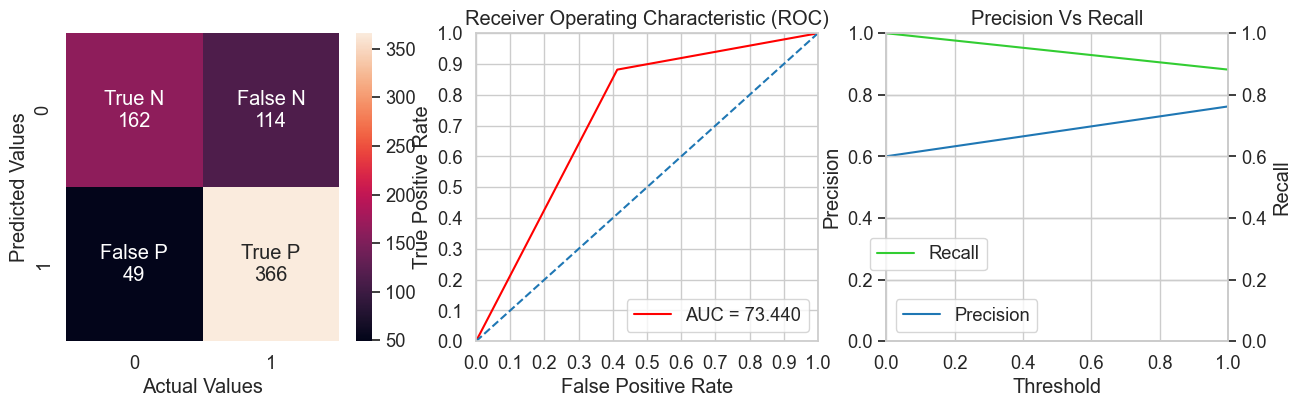

In [300]:
xgb = XGBClassifier(n_estimators=200)

params = {
        'subsample': [0.6, 0.8, 1.0],
        'max_depth': [3, 5, 7], 
        'learning_rate': [0.001, 0.01, 0.1],
        }

xgbGrid = GridSearchCV(xgb, params, cv = 5, scoring=acc, verbose=2)
xgbGrid.fit(X_train, Y_train)
print("Best set of hyperparameters: ", xgbGrid.best_params_)

xgb_model_Grid = XGBClassifier(n_estimators=200, learning_rate=xgbGrid.best_params_["learning_rate"],
                    max_depth=xgbGrid.best_params_["max_depth"],
                    subsample=xgbGrid.best_params_["subsample"])

xgb_model_Grid.fit(X_train, Y_train)
train_accuracy_XGB = xgb_model_Grid.score(X_train, Y_train)
print(f'Training Accuracy: {train_accuracy_log * 100:.6f}%')

predictions_XGBC_G = xgb_model_Grid.predict(X_test)
accBoostGrid=accuracy_score(Y_test, predictions_XGBC_G)
print("Accuracy test set - Boosting with Grid Searching: {0:.2%}".format(accBoostGrid))

f1_BoostGrid = f1_score(Y_test,predictions_XGBC_G, average='weighted')
precision_BoostGrid = precision_score(Y_test, predictions_XGBC_G, average='weighted')
recall_BoostGrid = recall_score(Y_test, predictions_XGBC_G, average='weighted')

class_report_XGBOOST_Grid = classification_report(Y_test, predictions_XGBC_G)
print(class_report_XGBOOST_Grid)

df_cm_xgb, df_perf_xgb = model_perf(xgb_model_Grid, Y_test, predictions_XGBC_G, "XGBGrid PCA", df_cm, df_perf, plot = True)

Here are the three key points from the XGBoost model's results:

- The XGBoost model has demonstrated a test accuracy of 76.41% and a weighted F1-score of 76%, which indicates strong predictive performance with a high rate of correctly labeled predictions, especially for the positive class.
- The classification report shows balanced precision and recall scores, with the model having a slightly higher ability to correctly identify the positive class.
- The AUC for XGBoost is 73.44%, which, while lower than Random Forest, still reflects a good capability to distinguish between the positive and negative classes. The ROC curve and precision-recall trade-off also suggest that the model has a consistent performance across different thresholds.

__XGBOOST Features Importance (weight)__

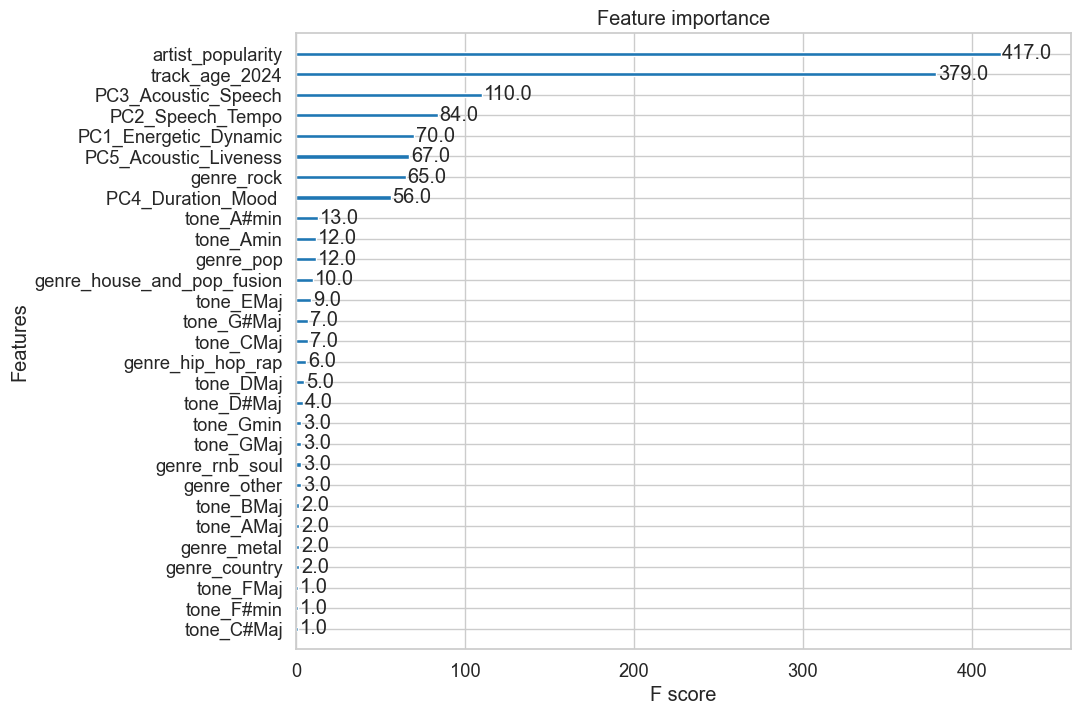

In [301]:
import xgboost as xgb
fig, ax = plt.subplots(figsize=(10, 8))
xgb.plot_importance(xgb_model_Grid, importance_type='weight', ax=ax) #weight
plt.show()


Based on the XGBoost feature importance plot you've shared, here are some insights:

1. **Artist Popularity Dominance**: Artist popularity is the most significant feature influencing the model's predictions, suggesting that the popularity of the artist is a strong predictor of a track's popularity.

2. **Track Age and PCA Components**: The age of the track (track_age_2024) and certain principal components related to acoustic qualities and speech (PC3_Acoustic_Speech) and tempo (PC2_Speech_Tempo) are also important features, indicating that these factors play a considerable role in the model's decision-making process.

3. **Genre and Tone Relevance**: While not as dominant as artist popularity or track age, specific genres and tones, such as rock and certain musical keys (e.g., A# minor), show up as relevant features, which may reflect their unique contributions to a track's popularity within the dataset.

##### AdaBoost


Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ................................learning_rate=0.001; total time=   0.4s
[CV] END ................................learning_rate=0.001; total time=   0.4s
[CV] END ................................learning_rate=0.001; total time=   0.4s
[CV] END ................................learning_rate=0.001; total time=   0.4s
[CV] END ................................learning_rate=0.001; total time=   0.4s
[CV] END .................................learning_rate=0.01; total time=   0.4s
[CV] END .................................learning_rate=0.01; total time=   0.4s
[CV] END .................................learning_rate=0.01; total time=   0.4s
[CV] END .................................learning_rate=0.01; total time=   0.4s
[CV] END .................................learning_rate=0.01; total time=   0.4s
[CV] END ..................................learning_rate=0.1; total time=   0.4s
[CV] END ..................................learni

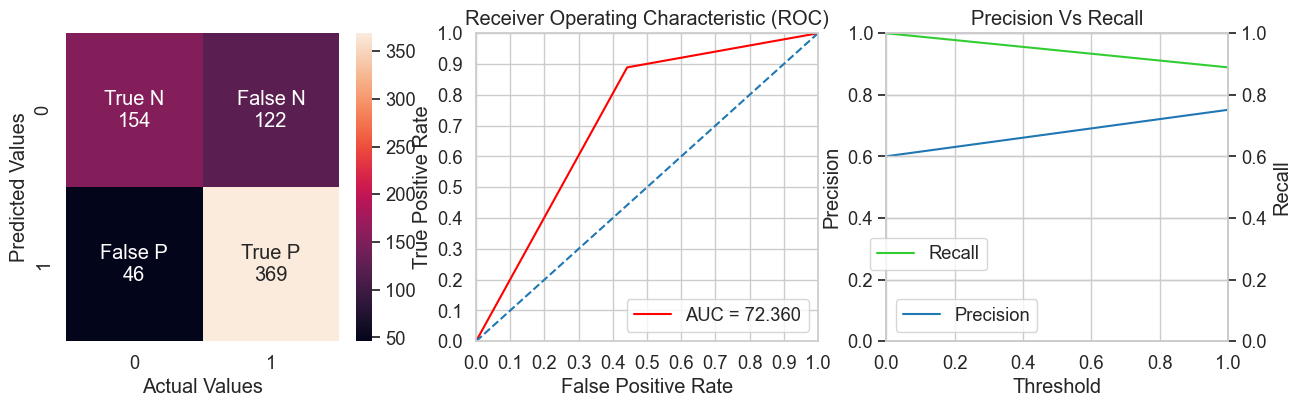

In [302]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(n_estimators=200)

params = {
        #'subsample': [0.6, 0.8, 1.0],
        #'max_depth': [3, 5, 7], 
        'learning_rate': [0.001, 0.01, 0.1],
        }

AdaGrid = GridSearchCV(ada, params, cv = 5, scoring=acc, verbose=2)
AdaGrid.fit(X_train, Y_train)
print("Best set of hyperparameters: ", AdaGrid.best_params_)

ada_model_Grid = AdaBoostClassifier(n_estimators=200, learning_rate=AdaGrid.best_params_["learning_rate"],
                    #max_depth=AdaGrid.best_params_["max_depth"],
                    #subsample=AdaGrid.best_params_["subsample"]
                    )

ada_model_Grid.fit(X_train, Y_train)
train_accuracy_ada = ada_model_Grid.score(X_train, Y_train)
print(f'Training Accuracy: {train_accuracy_log * 100:.6f}%')

predictions_Ada_G = ada_model_Grid.predict(X_test)
accAdaGrid=accuracy_score(Y_test, predictions_Ada_G)
print("Accuracy test set - Boosting with Grid Searching: {0:.2%}".format(accAdaGrid))

f1_AdaGrid = f1_score(Y_test,predictions_Ada_G, average='weighted')
precision_AdaGrid = precision_score(Y_test, predictions_Ada_G, average='weighted')
recall_AdaGrid = recall_score(Y_test, predictions_Ada_G, average='weighted')

class_report_Ada_Grid = classification_report(Y_test, predictions_Ada_G)
print(class_report_Ada_Grid)

df_cm_ada, df_perf_ada = model_perf(ada_model_Grid, Y_test, predictions_Ada_G, "XGBGrid PCA", df_cm, df_perf, plot = True)

Based on the results for the AdaBoost model, here are three insights:

- The AdaBoost model exhibits a test accuracy of roughly 75.68%, with a weighted F1-score for the test data at 75%, showcasing its effectiveness in balancing precision and recall, particularly for the positive class.
- Precision for the negative class is higher than for the positive class, indicating that the model is slightly more reliable in predicting the absence of popularity compared to its presence.
- The model's AUC of 72.36% is a bit lower compared to some other models like Random Forest, suggesting that while AdaBoost is good at class prediction, there might be other models that can better distinguish between the classes.

##### Gaussian Naive Bayes (Just for fun)

Best set of hyperparameters:  {'learning_rate': 0.01}
Training Accuracy: 76.382846%
Accuracy test set - Naive Bayes with Grid Searching: 75.69%
              precision    recall  f1-score   support

         0.0       0.74      0.63      0.68       276
         1.0       0.78      0.86      0.81       415

    accuracy                           0.77       691
   macro avg       0.76      0.74      0.75       691
weighted avg       0.76      0.77      0.76       691

Accuracy of Naive Bayes PCA for Test data is 76.55571635311144

F1-score of Naive Bayes PCA for Test data is 81.42201834862385

Classification report for Naive Bayes PCA is: 
               precision    recall  f1-score   support

         0.0       0.74      0.63      0.68       276
         1.0       0.78      0.86      0.81       415

    accuracy                           0.77       691
   macro avg       0.76      0.74      0.75       691
weighted avg       0.76      0.77      0.76       691

AUC for Naive Bayes PCA: 7

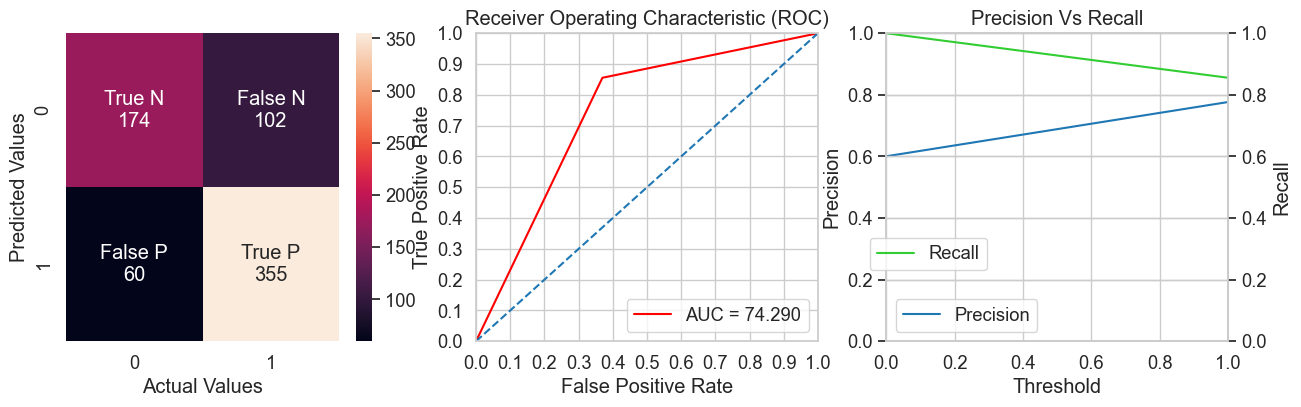

In [313]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()

# Define a range of var_smoothing values to test
params = {
    'var_smoothing': np.logspace(0,-9, num=100)
    }


gnbGrid = GridSearchCV(gnb, params, cv=5)  # 5-fold cross-validation

gnbGrid.fit(X_train, Y_train)
print("Best set of hyperparameters: ", AdaGrid.best_params_)

gnb_model_Grid = GaussianNB(var_smoothing=gnbGrid.best_params_["var_smoothing"],
                    
                    )

gnb_model_Grid.fit(X_train, Y_train)
train_accuracy_gnb = gnb_model_Grid.score(X_train, Y_train)
print(f'Training Accuracy: {train_accuracy_log * 100:.6f}%')

predictions_GNB_G = gnb_model_Grid.predict(X_test)
accGNBGrid=accuracy_score(Y_test, predictions_Ada_G)
print("Accuracy test set - Naive Bayes with Grid Searching: {0:.2%}".format(accGNBGrid))

f1_GNBGrid = f1_score(Y_test,predictions_GNB_G, average='weighted')
precision_GNBGrid = precision_score(Y_test, predictions_GNB_G, average='weighted')
recall_GNBGrid = recall_score(Y_test, predictions_GNB_G, average='weighted')

class_report_GNB_Grid = classification_report(Y_test, predictions_GNB_G)
print(class_report_GNB_Grid)

df_cm_GNB, df_perf_GNB = model_perf(gnb_model_Grid, Y_test, predictions_GNB_G, "Naive Bayes PCA", df_cm, df_perf, plot = True)


##### KNN
Note: We might have to many features for KNN, therefore we tested 1 KNN model with all our parameters even if we knew that this is not the optimal way and that the model might be fooled.

KNN M1

In [304]:
#first we have to standardize our training and test set we decid
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
#Data = w/O PCA
#PCA_Data = PCA
#min_max_scaler = MinMaxScaler()
#data = min_max_scaler.fit_transform(data)
# Initialize the StandardScaler
standard_scaler = StandardScaler()

# Fit on the training data
standard_scaler.fit(X_train)

# Transform both the training and the test data with the fitted scaler
X_train_sc = standard_scaler.transform(X_train)
X_test_sc = standard_scaler.transform(X_test)

Fitting 5 folds for each of 38 candidates, totalling 190 fits
[CV] END .....................n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END .....................n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END .....................n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END .....................n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END .....................n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END ....................n_neighbors=1, weights=distance; total time=   0.0s
[CV] END ....................n_neighbors=1, weights=distance; total time=   0.0s
[CV] END ....................n_neighbors=1, weights=distance; total time=   0.0s
[CV] END ....................n_neighbors=1, weights=distance; total time=   0.0s
[CV] END ....................n_neighbors=1, weights=distance; total time=   0.0s
[CV] END .....................n_neighbors=2, weights=uniform; total time=   0.0s
[CV] END .....................n_neighbors=2, we

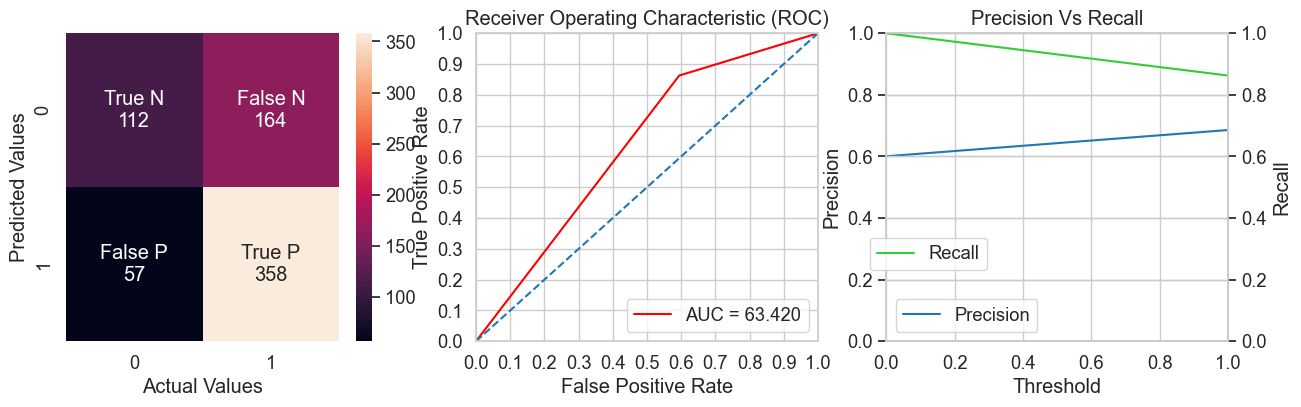

In [305]:
knn_classifier = KNeighborsClassifier()
parameters = {
    "n_neighbors": range(1, 20),
    "weights": ["uniform", "distance"]
}
knn_Grid_M2 = GridSearchCV(KNeighborsClassifier(), parameters, cv=5, verbose=2)
knn_Grid_M2 .fit(X_train_sc, Y_train)
print("Best parameters: ", knn_Grid_M2 .best_params_)

train_preds_grid = knn_Grid_M2 .predict(X_train_sc)
predictions = knn_Grid_M2 .predict(X_test_sc)
knn_classifier_M2 = KNeighborsClassifier(n_neighbors=knn_Grid_M2.best_params_['n_neighbors'],weights=knn_Grid_M2.best_params_['weights'])

knn_classifier_M2.fit(X_train_sc, Y_train)
train_accuracy_knnM2 = knn_classifier_M2.score(X_train, Y_train)
print(f'Training Accuracy: {train_accuracy_log * 100:.6f}%')

# Predictions (on test set, obviously)
knn_predictions_M2 = knn_classifier_M2.predict(X_test_sc)

# Calculate error_rate
acc_KNN_M2 = accuracy_score(Y_test, knn_predictions_M2)
error_rate_M2 = 1 - accuracy_score(Y_test, knn_predictions_M2)
print("Error (k=5): {0:.2%}".format(error_rate_M2))

f1_KNN_M2 = f1_score(Y_test,knn_predictions_M2, average='weighted')
precision_KNN_M2 = precision_score(Y_test, knn_predictions_M2, average='weighted')
recall_KNN_M2 = recall_score(Y_test, knn_predictions_M2, average='weighted')

class_report_KNN_M2 = classification_report(Y_test, knn_predictions_M2)
print(class_report_KNN_M2)

df_cm_knn, df_perf_knn = model_perf(knn_classifier_M2, Y_test, knn_predictions_M2, "KNN M2 Grid PCA", df_cm, df_perf, plot = True)

## EVALUATION THE MODELS

At the end, by comparing the different model, and examining different hyperparameters in the "testing model phase" we decided to go with the XGBoost Model as a core component of HarmonySeeker for the following three points:  

1. **`High Accuracy`**: Demonstrates strong predictive capability with robust performance metrics.
2. **`Regularization Techniques`**: Helps prevent overfitting, ensuring the model's generalization to new data.
3. **`Efficiency and Scalability`**: Manages large datasets quickly, crucial for practical applications.

XGBoost's combination of performance, reliability, and ease of interpretation makes it an excellent choice for our project's needs.


In [306]:
class_report_variables = [var for var in globals() if var.startswith("class_report")]
print(class_report_variables)


['class_report_PCA_Logit', 'class_report_Decision_Tree_Grid', 'class_report_Bagging_Grid', 'class_report_RandomForest_Grid', 'class_report_XGBOOST', 'class_report_XGBOOST_Grid', 'class_report_KNN_M2', 'class_report_KNN_M3', 'class_report_variables', 'class_report_Ada_Grid', 'class_report_GNB_Grid']


In [307]:
categ = ['Log','DT', 'Bagg', 'RF','Boost', 'KNN_M2', 'AdaBoost','GaussianNB']
values = [acc_log, accDTGrid, accBaggGrid, accRFGrid, accBoostGrid, acc_KNN_M2, accAdaGrid, accGNBGrid]
#colors = ['blue', 'darkblue', 'pink', 'red', 'yellow', 'orange', 'lightgreen', 'darkgreen'] 

df = pd.DataFrame({'Model': categ, 'Accuracy': values})

fig = px.bar(df, x='Model', y='Accuracy', color='Model', range_y=[0.6, 0.8], text='Accuracy')
fig.update_traces(texttemplate='%{text:.2%}', textposition='outside')
fig.update_layout(
    xaxis_title='',
    yaxis_title='% Accuracy',
    title='% Accuracy Comparison'
)
fig.show()


In [308]:
categ = ['Log','DT', 'Bagg', 'RF','Boost', 'KNN_M2', 'AdaBoost','GaussianNB']
values = [f1_Log_PCA,f1_TreeGrid, f1_BaggGrid, f1_RFGrid, f1_BoostGrid,f1_KNN_M2,f1_AdaGrid,f1_GNBGrid]
#colors = ['blue', 'darkblue', 'pink', 'red', 'yellow', 'orange', 'lightgreen', 'darkgreen', 'green','purple','cyan', 'magenta'] 

df_f1 = pd.DataFrame({'Model': categ, 'F1 weighted': values})

fig = px.bar(df_f1, x='Model', y='F1 weighted', color='Model', range_y=[0.6, 0.8], text='F1 weighted')
fig.update_traces(texttemplate='%{text:.2%}', textposition='outside')
fig.update_layout(
    xaxis_title='',
    yaxis_title='% Weighted F1',
    title='% Weighted F1 Comparison'
)
fig.show()

In [309]:
categ = ['Log','DT', 'Bagg', 'RF','Boost', 'KNN_M2', 'AdaBoost','GaussianNB']
values = [precision_Log_PCA,precision_TreeGrid, precision_BaggGrid, precision_RFGrid, precision_BoostGrid, precision_KNN_M2,precision_AdaGrid,precision_GNBGrid]

df_precision = pd.DataFrame({'Model': categ, 'Precision': values})

fig = px.bar(df_precision, x='Model', y='Precision', color='Model', range_y=[0.6, 0.8], text='Precision')
fig.update_traces(texttemplate='%{text:.2%}', textposition='outside')
fig.update_layout(
    xaxis_title='',
    yaxis_title='% Precision',
    title='% Precision Comparison'
)
fig.show()

In [310]:
categ = ['Log','DT', 'Bagg', 'RF','Boost', 'KNN_M2', 'AdaBoost','GaussianNB']
values = [recall_Log_PCA,recall_TreeGrid, recall_BaggGrid, recall_RFGrid, recall_BoostGrid, recall_KNN_M2, recall_AdaGrid,recall_GNBGrid]


df_recall = pd.DataFrame({'Model': categ, 'Recall': values})

fig = px.bar(df_recall, x='Model', y='Recall', color='Model', range_y=[0.6, 0.8], text='Recall')
fig.update_traces(texttemplate='%{text:.2%}', textposition='outside')
fig.update_layout(
    xaxis_title='',
    yaxis_title='% Precision',
    title='% Recall Comparison'
)
fig.show()

#### Further Investigations

Logistic Regression
Accuracy of Log PCA for Test data is 75.68740955137481

F1-score of Log PCA for Test data is 80.77803203661327

Classification report for Log PCA is: 
               precision    recall  f1-score   support

         0.0       0.73      0.62      0.67       276
         1.0       0.77      0.85      0.81       415

    accuracy                           0.76       691
   macro avg       0.75      0.73      0.74       691
weighted avg       0.75      0.76      0.75       691

AUC for Log PCA: 73.33



Decision Tree
Accuracy of DT PCA for Test data is 75.68740955137481

F1-score of DT PCA for Test data is 80.9090909090909

Classification report for DT PCA is: 
               precision    recall  f1-score   support

         0.0       0.74      0.61      0.67       276
         1.0       0.77      0.86      0.81       415

    accuracy                           0.76       691
   macro avg       0.75      0.73      0.74       691
weighted avg       0.75      0.76      0.75       691

AUC for DT PCA: 73.15

Bagging
Accuracy of BaggGrid PCA for Test data is 76.98986975397975

F1-score of BaggGrid PCA for Test data is 82.4696802646086

Classification report for BaggGrid PCA is: 
               precision    recall  f1-score   support

         0.0       0.79      0.57      0.67       276
         1.0       0.76      0.90      0.82       415

    accuracy                           0.77       691
   macro avg       0.78      0.74      0.74       691
weighted avg       0.77      0.77      0.7

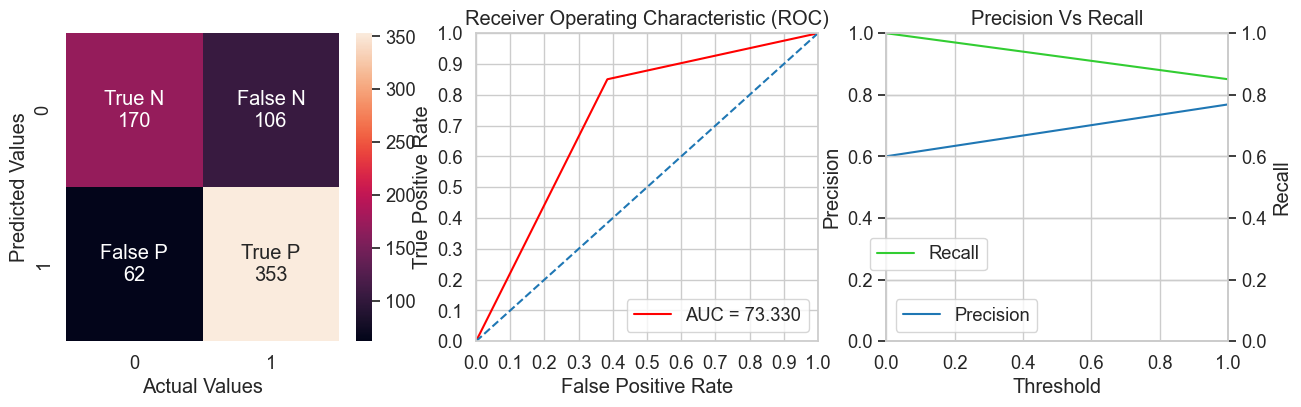

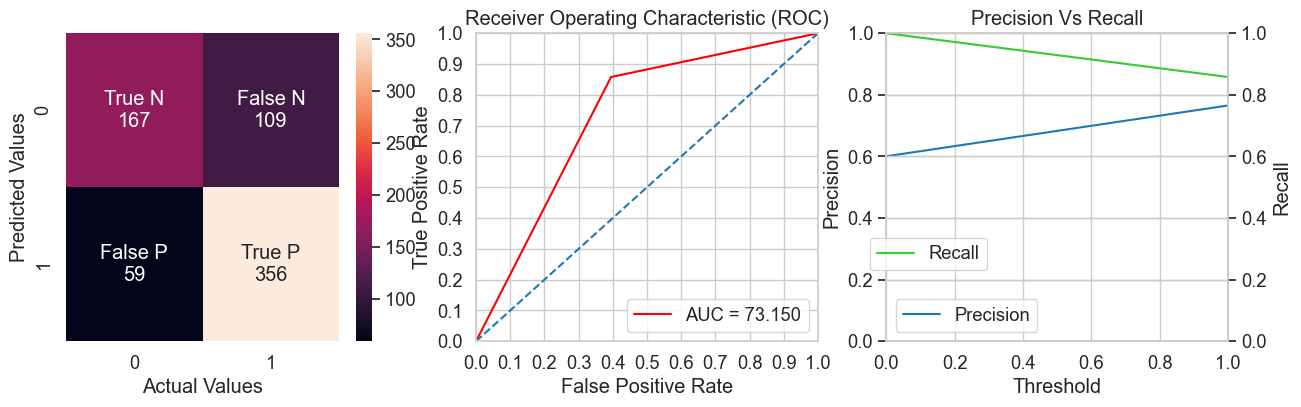

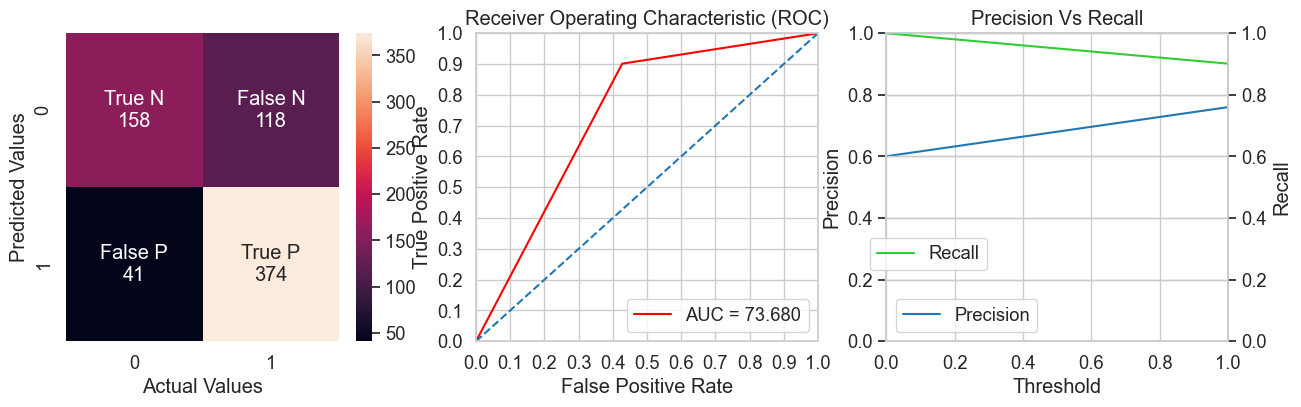

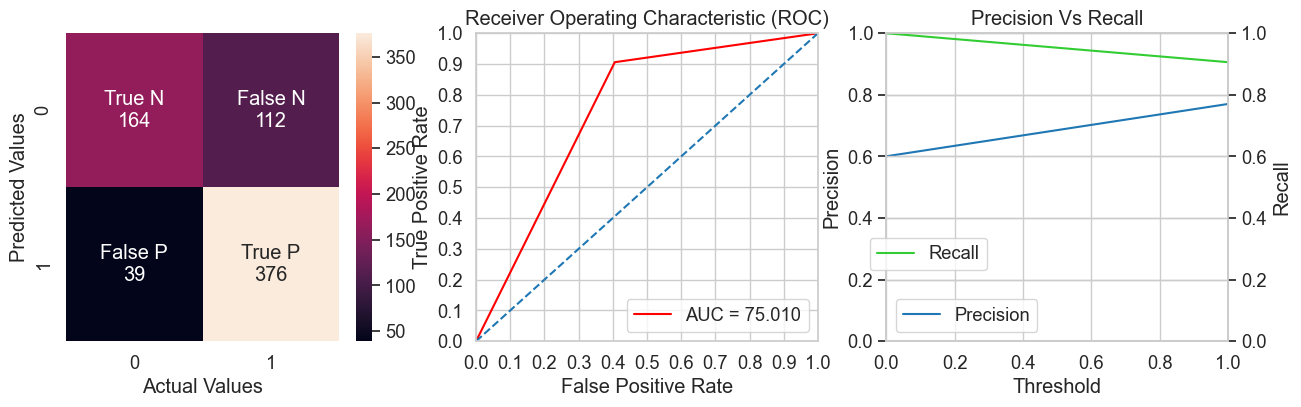

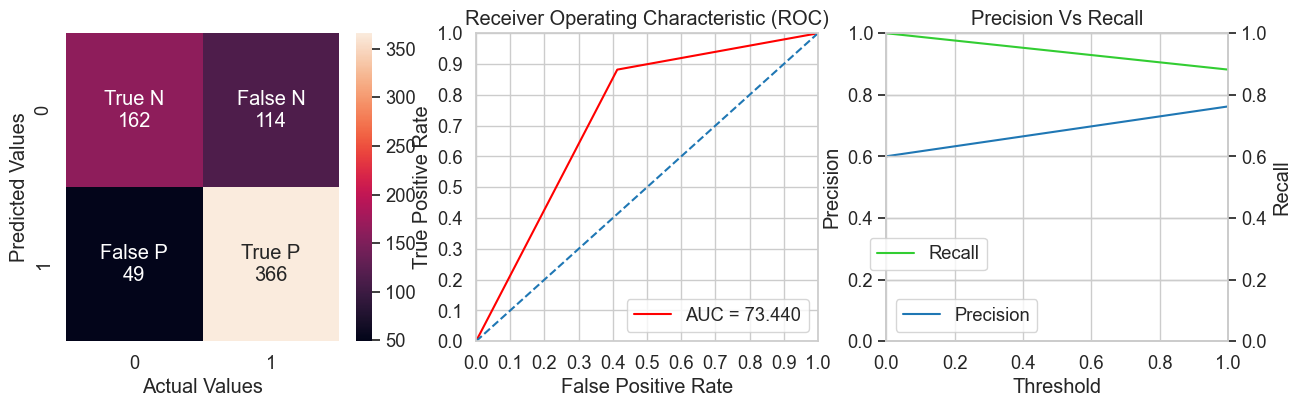

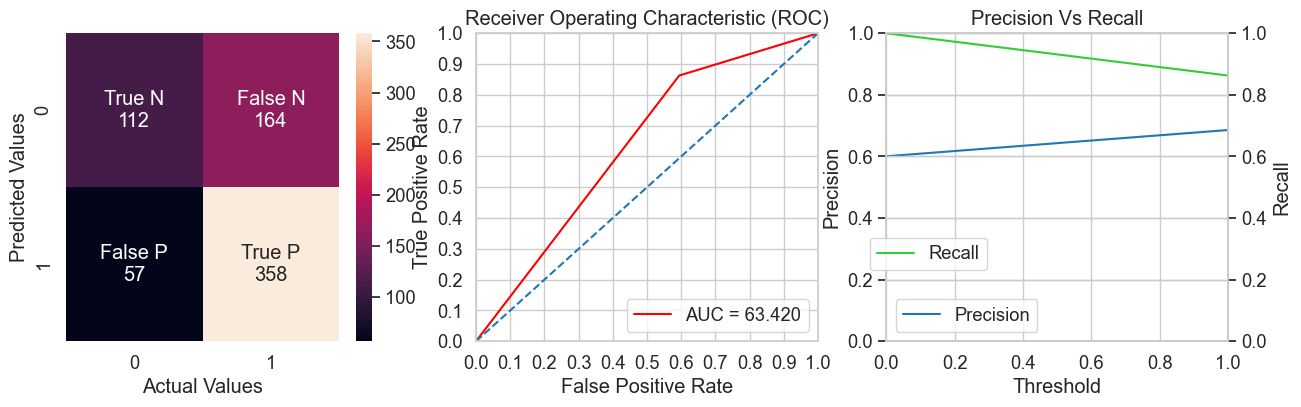

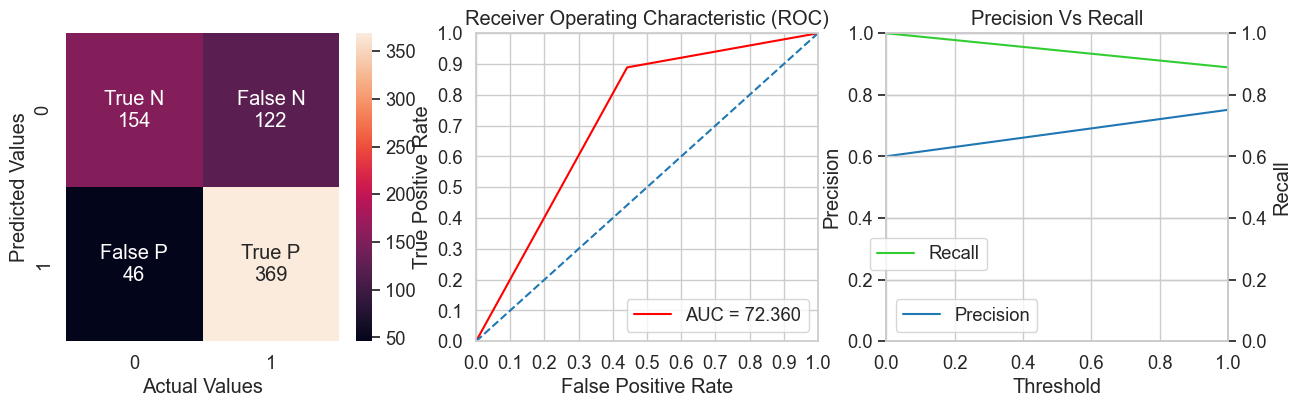

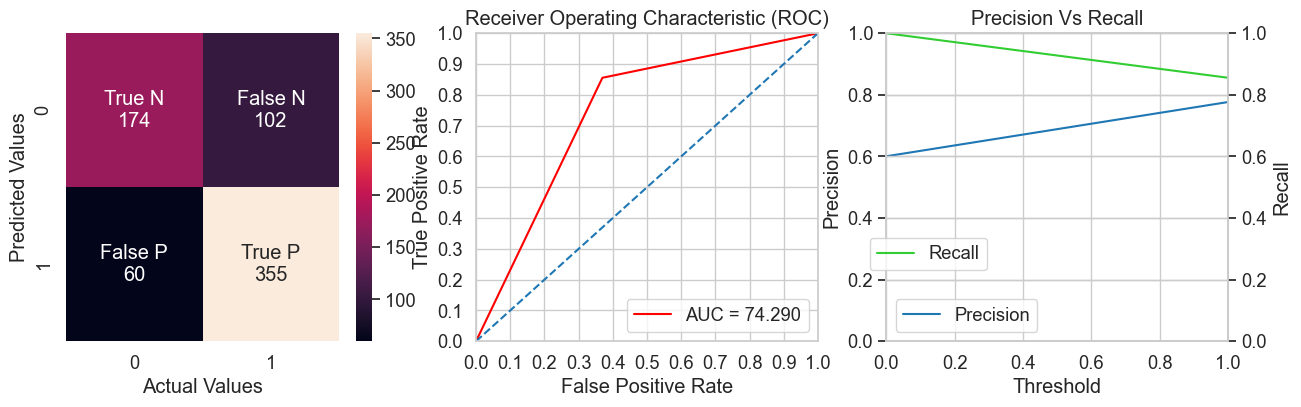

In [311]:
print("Logistic Regression")
df_cm_log, df_perf_log = model_perf(log_reg_PCA, Y_test, predictions_log_PCA, "Log PCA", df_cm, df_perf, plot = True)
print("Decision Tree")
df_cm_dt, df_perf_dt = model_perf(tree_pruned, Y_test, predictions_DT_G, "DT PCA", df_cm, df_perf, plot = True)
print("Bagging")
df_cm_bag, df_perf_bag = model_perf(BaggGrid, Y_test, predictions_bagg_G, "BaggGrid PCA", df_cm, df_perf, plot = True)
print("RandomFores")
df_cm_rf, df_perf_rf = model_perf(model, Y_test, predictions_RF_G, "RF PCA", df_cm, df_perf, plot = True)
print("XGBoost")
df_cm_xgb, df_perf_xgb = model_perf(xgb_model_Grid, Y_test, predictions_XGBC_G, "XGBGrid PCA", df_cm, df_perf, plot = True)
print("KNN M2")
df_cm_knn, df_perf_knn = model_perf(knn_classifier_M2, Y_test, knn_predictions_M2, "KNN M2 Grid PCA", df_cm, df_perf, plot = True)
print("AdaBoost")
df_cm_ada, df_perf_ada = model_perf(ada_model_Grid, Y_test, predictions_Ada_G, "XGBGrid PCA", df_cm, df_perf, plot = True)
print("GaussianNB")
df_cm_GNB, df_perf_GNB = model_perf(gnb_model_Grid, Y_test, predictions_GNB_G, "XGBGrid PCA", df_cm, df_perf, plot = True)



Exporting Model


In [312]:
#from joblib import dump

# Assume `xgb_model_Grid` is your trained model variable
#dump(xgb_model_Grid, '/Users/lucazosso/Desktop/IE_Course/Term_2/Machine Learning II/Group Assignement/MLOps/xgb_model_Grid.joblib')